DA6401 Assignment-1

NAME: MOUSINA BARMAN

ROLL: MA23M011



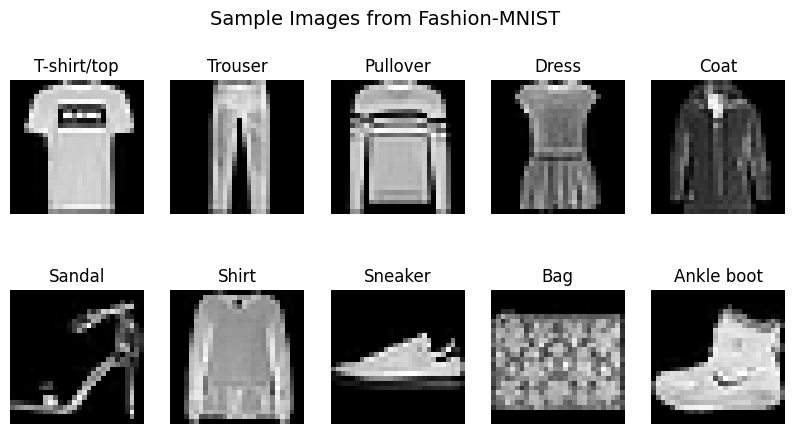

In [13]:
#For niumerical operation import numpy
import numpy as np
#For visualization import Matplotlib
import matplotlib.pyplot as plt
#For logging import Weights & Biases
import wandb
#import for fashion-mnist dataset from keras
from keras.datasets import fashion_mnist

# Initialize wandb for logging
wandb.init(project="DA6401_Assignment1_ma23m011", name="sample-images-1")

# Load fashion-mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Class labels define based on fashion-mnist categories
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

#Initialize empty list to store sample  image and their labels
sample_images = []
sample_labels = []

#use for loop to add sample image and their class
for class_id in range(10):
    idx = np.where(y_train == class_id)[0][0] # Find the first index where y_train and class label equal
    sample_images.append(x_train[idx]) # Add the image to the list
    sample_labels.append(class_labels[class_id]) # Add the label to the list

# With caption log images to wandb
wandb.log({"Sample Images": [wandb.Image(img, caption=label) for img, label in zip(sample_images, sample_labels)]})


fig, axes = plt.subplots(2, 5, figsize=(10, 5)) # plot 2x5 grid image
fig.suptitle("Sample Images from Fashion-MNIST", fontsize=14)# Add a title

# Plot each image in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray') # Display image in grayscale
    ax.set_title(sample_labels[i]) # Set the title as the class label
    ax.axis("off") # Hide axes

# Show the plotted images
plt.show()

# Finish the wandb logging run
wandb.finish()


In [14]:
import numpy as np
#import for fashion-mnist dataset from keras
from keras.datasets import fashion_mnist

# Load fashion-mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize  0 to 1 pixel values and flatten images convert 1D vector
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# From training dataset 60000 sample images create validation set
x_val = x_train[54000:]
y_val = y_train[54000:]

# For training using 54000 images
x_train = x_train[:54000]
y_train = y_train[:54000]

# Convert labels into one-hot encoding
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))# Create a zero matrix
    one_hot[np.arange(y.size), y] = 1 # Set the corresponding class index to 1
    return one_hot

#training,test and validation labels apply one hot encoding
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

#Define Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[128, 64], output_size=10,
                 learning_rate=0.01, optimizer="sgd", weight_init="random",
                 activation="sigmoid", weight_decay=0.0):
        #initialize parameters for feedforward neural network
        self.layers = [input_size] + hidden_layers + [output_size]
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.activation = activation
        self.weight_decay = weight_decay
        self.init_weights()

        #For different optimizer technique use optimizer-specific variables
        self.momentum = 0.9 #mumentum parameter
        self.beta1 = 0.9  # Adam/Nadam parameter
        self.beta2 = 0.999 # Adam/Nadam parameter
        self.epsilon = 1e-8
        self.velocity = [np.zeros_like(w) for w in self.weights] #mumentum velocity
        self.squared_grads = [np.zeros_like(w) for w in self.weights]
        self.m = [np.zeros_like(w) for w in self.weights] #adam 1st moment
        self.v = [np.zeros_like(w) for w in self.weights] #adam 2nd moment
        self.t = 0  # Time step

    def init_weights(self):
        # Initialize weights and biases
        self.weights = [] #Empty list define to store weight matrix
        self.biases = [] #Empty list define to store bias vector
        #loop use for random and xavier initialization
        for i in range(len(self.layers) - 1):
            if self.weight_init == "random":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)
            elif self.weight_init == "xavier":
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(1 / self.layers[i]))
            self.biases.append(np.zeros((1, self.layers[i+1])))

    # Calculate activation function value based user expectation.
    def activation_function(self, z):
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-np.clip(z, -10, 10)))
        elif self.activation == "tanh":
            return np.tanh(z)
        elif self.activation == "relu":
            return np.maximum(0, z)

    #calculate activation function derivative
    def activation_derivative(self, a):
        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)

    #For output layer calculate softmax function value
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    #Forward propagation
    def forward(self, X):
        #store each layer activation value
        activations = [X]
        #store weighted sum value
        z_values = []

         #Use for loop for calculate weighted sum and  apply activation function
        for i in range(len(self.weights) - 1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            activations.append(self.activation_function(z))

        #Final layer computation using softmax function
        z_out = np.dot(activations[-1], self.weights[-1]) + self.biases[-1]
        z_values.append(z_out)
        activations.append(self.softmax(z_out))

        return activations, z_values

    #Cross entropy loss computation with L2 ragularization
    def compute_loss(self, y_true, y_pred):
        #cross entropy loss
        loss = -np.sum(y_true * np.log(y_pred + self.epsilon)) / y_true.shape[0]
        #L2 regularization
        l2_penalty = self.weight_decay * sum(np.sum(w**2) for w in self.weights) / 2
        return loss + l2_penalty

    #Compute accuracy by comparing true vs predicted labels.
    def compute_accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        return correct_predictions / y_true.shape[0]

     #Use backpropagation to calculate gradients.
    def backward(self, X, y_true, activations, z_values):
        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        #Compute output layer gradient
        dL_dz = activations[-1] - y_true
        gradients_w[-1] = np.dot(activations[-2].T, dL_dz) + self.weight_decay * self.weights[-1]
        gradients_b[-1] = np.sum(dL_dz, axis=0, keepdims=True)

        # Compute Hidden layers gradient
        for i in reversed(range(len(self.weights) - 1)):
            dL_dz = np.dot(dL_dz, self.weights[i+1].T) * self.activation_derivative(activations[i+1])
            gradients_w[i] = np.dot(activations[i].T, dL_dz) + self.weight_decay * self.weights[i]
            gradients_b[i] = np.sum(dL_dz, axis=0, keepdims=True)

        return gradients_w, gradients_b

    # Apply gradient updates using different optimizers.
    def update_weights(self, gradients_w, gradients_b):
        self.t += 1  # Update time step for Adam/Nadam

        for i in range(len(self.weights)):
            # Apply stochastic gradient descent
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * gradients_w[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            #Apply momentum gradient descent
            elif self.optimizer == "momentum":
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] += self.velocity[i]
                self.biases[i] -= self.learning_rate * gradients_b[i]

            #Apply nestrov
            elif self.optimizer == "nesterov":
                temp_weights = self.weights[i] + self.momentum * self.velocity[i]
                self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * gradients_w[i]
                self.weights[i] = temp_weights + self.velocity[i]

            #Apply rmsprop optimizer
            elif self.optimizer == "rmsprop":
                self.squared_grads[i] = 0.9 * self.squared_grads[i] + 0.1 * (gradients_w[i] ** 2)
                self.weights[i] -= self.learning_rate * gradients_w[i] / (np.sqrt(self.squared_grads[i]) + self.epsilon)

            #Apply adam optimizer
            elif self.optimizer == "adam":
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (gradients_w[i] ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            #Apply nadam optimizer
            elif self.optimizer == "nadam":
                m_hat = (self.beta1 * self.m[i] + (1 - self.beta1) * gradients_w[i]) / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * (self.momentum * m_hat + (1 - self.momentum) * gradients_w[i]) / (np.sqrt(v_hat) + self.epsilon)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        #Train nural network using mini-batch gradient descent.
        num_samples = X_train.shape[0]

        #use for loop for shuffle training data
        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            # Mini-batch training
            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                #Use forward pass
                activations, z_values = self.forward(X_batch)

                # Compute gradients of weight and bias using backpropagation
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, z_values)

                # Update weights and bias
                self.update_weights(gradients_w, gradients_b)

            # Compute training loss & accuracy
            train_activations, _ = self.forward(X_train)
            Train_loss = self.compute_loss(y_train, train_activations[-1])
            Train_accuracy = compute_accuracy(y_train, train_activations[-1])

            # Compute validation loss & accuracy
            val_activations, _ = self.forward(X_val)
            Val_loss = self.compute_loss(y_val, val_activations[-1])
            Val_accuracy = compute_accuracy(y_val, val_activations[-1])
            wandb.log({'Train_loss': Train_loss})
            wandb.log({'Train_accuracy': Train_accuracy })
            wandb.log({'epoch': epoch + 1})
            wandb.log({'Val_loss': Val_loss})
            wandb.log({'Val_accuracy': Val_accuracy })

            print(f"Epoch {epoch+1}: Train Loss = {Train_loss:.4f}, Train Acc = {Train_accuracy:.4f}, Val Loss = {Val_loss:.4f}, Val Acc = {Val_accuracy:.4f}")

def compute_accuracy(y_true, y_pred):
        #Compute accuracy by comparing true vs predicted labels.
        correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
        accuracy = correct_predictions / y_true.shape[0]
        return accuracy*100

In [26]:
# Create a neural network with a flexible architecture
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)

# Forward pass example
sample_input = x_train[:50]  # Take 5 sample images
# print(sample_input.shape)
output_probs = nn.forward(sample_input)[0]  # Get output probability distribution

# Print predictions
#print("Predicted class probabilities:\n", output_probs)
print("Predicted classes:", np.argmax(output_probs[3], axis=1))

Predicted classes: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [23]:
# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd", weight_init="xavier", activation="relu", weight_decay=0.0005)

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)


In [20]:
!pip install wandb

In [5]:
import wandb
import numpy as np
#For easy attribute access import SimpleNamespace
from types import SimpleNamespace
# import Random  for randomization
import random

In [6]:
key = input('Enter your API:')
wandb.login(key=key)

Enter your API:580e769ee2f34eafdded556ce52aaf31c265ad3b


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
# Define the sweep configuration
sweep_config = {
    'method': 'bayes',# Use Bayesian optimization
    'name' : 'sweep cross entropy-14', #sweep name
    'metric': {
      'name': 'Val_accuracy',
      'goal': 'maximize' # maximize validation accuracy
    },
    'parameters': {
        'epochs': {
            'values': [5,10] #number of training epoch
        },
        'hidden_layers':{
            'values':[3,4,5] #number of hidden layer
        },
         'hidden_size':{
            'values':[32,64,128] #hidden layer size
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5] # Regularization
        },
        'learning_rate': {
            'values': [1e-3, 1e-4] # Learning rate
        },
        'optimizer': {
            'values': ['rmsprop', 'nadam','adam', 'nag','mgd','sgd'] # Optimizers
        },
        'batch_size':{
            'values':[16,32,64] # Batch sizes for training
        },
        'weight_init': {
            'values': ['xavier','random'] # Weight initialization
        },
        'activation': {
            'values': ['relu','tanh','sigmoid'] # Activation function
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401_Assignment1_ma23m011')

Create sweep with ID: dba8pg3v
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DA6401_Assignment1_ma23m011/sweeps/dba8pg3v


In [12]:
def main():
    with wandb.init() as run:
      # Generate a unique run name based on the hyperparameters
        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-regu_"+str(wandb.config.weight_decay)+"-eta_"+str(wandb.config.learning_rate)+"-optmz_"+wandb.config.optimizer+"-batch_"+str(wandb.config.batch_size)+"-wght_"+wandb.config.weight_init
        wandb.run.name=run_name
        # Create a Neural Network with the selected hyperparameters
        nn = NeuralNetwork(input_size=784, hidden_layers=[wandb.config.hidden_size] * wandb.config.hidden_layers, output_size=10, learning_rate=wandb.config.learning_rate, optimizer=wandb.config.optimizer, weight_init=wandb.config.weight_init, activation=wandb.config.activation, weight_decay=wandb.config.weight_decay)
        nn.train(x_train, y_train, x_val, y_val, epochs=wandb.config.epochs, batch_size=wandb.config.batch_size)


# # Create Neural Network
# nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, learning_rate=0.01, optimizer="sgd")

# # Train the model and track accuracy
# nn.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=32)

wandb.agent(sweep_id, function=main,count=100) # calls main function for count number of times.
# Finish the W&B run
wandb.finish()

wandb: Agent Starting Run: b0he9cu5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3821, Train Acc = 12.5370, Val Loss = 2.3849, Val Acc = 12.0667
Epoch 2: Train Loss = 2.3821, Train Acc = 12.5370, Val Loss = 2.3849, Val Acc = 12.0667
Epoch 3: Train Loss = 2.3821, Train Acc = 12.5370, Val Loss = 2.3849, Val Acc = 12.0667
Epoch 4: Train Loss = 2.3821, Train Acc = 12.5370, Val Loss = 2.3849, Val Acc = 12.0667
Epoch 5: Train Loss = 2.3821, Train Acc = 12.5370, Val Loss = 2.3849, Val Acc = 12.0667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,12.53704
Train_loss,2.38206
Val_accuracy,12.06667
Val_loss,2.3849
epoch,5


wandb: Agent Starting Run: pfwlt1cr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


<ipython-input-3-e28b4749cf70>:88: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: mpj3d0gw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.9680, Train Acc = 19.9963, Val Loss = 1.9679, Val Acc = 19.9833
Epoch 2: Train Loss = 1.7041, Train Acc = 20.5963, Val Loss = 1.7053, Val Acc = 20.0167
Epoch 3: Train Loss = 1.5622, Train Acc = 36.8630, Val Loss = 1.5631, Val Acc = 36.1000
Epoch 4: Train Loss = 1.3837, Train Acc = 41.9944, Val Loss = 1.3816, Val Acc = 41.1667
Epoch 5: Train Loss = 1.2771, Train Acc = 45.8778, Val Loss = 1.2737, Val Acc = 45.4833
Epoch 6: Train Loss = 1.1941, Train Acc = 49.1500, Val Loss = 1.1929, Val Acc = 48.6000
Epoch 7: Train Loss = 1.1138, Train Acc = 52.5907, Val Loss = 1.1129, Val Acc = 52.3333
Epoch 8: Train Loss = 1.0401, Train Acc = 59.1500, Val Loss = 1.0410, Val Acc = 59.0500
Epoch 9: Train Loss = 0.9835, Train Acc = 58.5130, Val Loss = 0.9838, Val Acc = 58.7333
Epoch 10: Train Loss = 0.9396, Train Acc = 62.0278, Val Loss = 0.9430, Val Acc = 62.3500


Train_accuracy,▁▁▄▅▅▆▆█▇█
Train_loss,█▆▅▄▃▃▂▂▁▁
Val_accuracy,▁▁▄▅▅▆▆▇▇█
Val_loss,█▆▅▄▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,62.02778
Train_loss,0.93959
Val_accuracy,62.35
Val_loss,0.94295
epoch,10


wandb: Agent Starting Run: 9vqjne10 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 2: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 3: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 4: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 5: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 6: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 7: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 8: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 9: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833
Epoch 10: Train Loss = 2.3676, Train Acc = 9.9907, Val Loss = 2.3681, Val Acc = 10.0833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,2.36758
Val_accuracy,10.08333
Val_loss,2.36811
epoch,10


wandb: Agent Starting Run: 2hoy8kla with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3109, Train Acc = 10.0296, Val Loss = 2.3112, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3147, Train Acc = 9.9389, Val Loss = 2.3116, Val Acc = 10.5500
Epoch 3: Train Loss = 2.3068, Train Acc = 9.9648, Val Loss = 2.3051, Val Acc = 10.3167
Epoch 4: Train Loss = 2.3050, Train Acc = 10.0648, Val Loss = 2.3058, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3049, Train Acc = 9.9907, Val Loss = 2.3059, Val Acc = 10.0833
Epoch 6: Train Loss = 2.3040, Train Acc = 10.0167, Val Loss = 2.3034, Val Acc = 9.8500
Epoch 7: Train Loss = 2.3050, Train Acc = 10.0296, Val Loss = 2.3061, Val Acc = 9.7333
Epoch 8: Train Loss = 2.3054, Train Acc = 9.9389, Val Loss = 2.3036, Val Acc = 10.5500
Epoch 9: Train Loss = 2.3032, Train Acc = 10.0167, Val Loss = 2.3028, Val Acc = 9.8500
Epoch 10: Train Loss = 2.3040, Train Acc = 9.9963, Val Loss = 2.3033, Val Acc = 10.0333


Train_accuracy,▆▁▂█▄▅▆▁▅▄
Train_loss,▆█▃▂▂▂▂▂▁▁
Val_accuracy,▃█▇▁▅▄▃█▄▅
Val_loss,██▃▃▄▂▄▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.30402
Val_accuracy,10.03333
Val_loss,2.30331
epoch,10


wandb: Agent Starting Run: gi3a0kqm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 31.7474, Train Acc = 82.1796, Val Loss = 31.7475, Val Acc = 81.9500
Epoch 2: Train Loss = 25.0063, Train Acc = 83.5296, Val Loss = 25.0108, Val Acc = 83.3667
Epoch 3: Train Loss = 22.1231, Train Acc = 82.4463, Val Loss = 22.1292, Val Acc = 81.9333
Epoch 4: Train Loss = 20.7665, Train Acc = 85.3148, Val Loss = 20.7770, Val Acc = 84.6167
Epoch 5: Train Loss = 20.2890, Train Acc = 84.0481, Val Loss = 20.3014, Val Acc = 83.1500


Train_accuracy,▁▄▂█▅
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▁█▄
Val_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_accuracy,84.04815
Train_loss,20.28897
Val_accuracy,83.15
Val_loss,20.30137
epoch,5


wandb: Agent Starting Run: cu9sjerp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


<ipython-input-3-e28b4749cf70>:88: RuntimeWarning: overflow encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: wnukvgk7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3188, Train Acc = 10.0296, Val Loss = 2.3190, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3176, Train Acc = 10.0167, Val Loss = 2.3176, Val Acc = 9.8500
Epoch 3: Train Loss = 2.3162, Train Acc = 10.0296, Val Loss = 2.3161, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3155, Train Acc = 9.9389, Val Loss = 2.3150, Val Acc = 10.5500
Epoch 5: Train Loss = 2.3150, Train Acc = 10.0167, Val Loss = 2.3156, Val Acc = 9.8500
Epoch 6: Train Loss = 2.3136, Train Acc = 10.0833, Val Loss = 2.3143, Val Acc = 9.2500
Epoch 7: Train Loss = 2.3129, Train Acc = 9.9648, Val Loss = 2.3129, Val Acc = 10.3167
Epoch 8: Train Loss = 2.3119, Train Acc = 10.0833, Val Loss = 2.3123, Val Acc = 9.2500
Epoch 9: Train Loss = 2.3122, Train Acc = 10.0167, Val Loss = 2.3126, Val Acc = 9.8500
Epoch 10: Train Loss = 2.3110, Train Acc = 10.0833, Val Loss = 2.3117, Val Acc = 9.2500


Train_accuracy,▅▅▅▁▅█▂█▅█
Train_loss,█▇▆▅▅▃▃▂▂▁
Val_accuracy,▄▄▄█▄▁▇▁▄▁
Val_loss,█▇▅▄▅▃▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.31099
Val_accuracy,9.25
Val_loss,2.31167
epoch,10


wandb: Agent Starting Run: vc3o4pn2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3033, Train Acc = 10.0833, Val Loss = 2.3034, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3033, Train Acc = 10.0833, Val Loss = 2.3034, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3033, Train Acc = 10.0833, Val Loss = 2.3035, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3033, Train Acc = 10.0648, Val Loss = 2.3035, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3033, Train Acc = 10.0648, Val Loss = 2.3035, Val Acc = 9.4167


Train_accuracy,███▁▁
Train_loss,█▄▁▁▁
Val_accuracy,▁▁▁██
Val_loss,▁▄▇██
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,2.30331
Val_accuracy,9.41667
Val_loss,2.3035
epoch,5


wandb: Agent Starting Run: lzoxqjjb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3027, Train Acc = 10.0833, Val Loss = 2.3028, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3027, Train Acc = 10.0833, Val Loss = 2.3031, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3019, Train Acc = 10.0648, Val Loss = 2.3025, Val Acc = 9.4167
Epoch 4: Train Loss = 1.3004, Train Acc = 44.2019, Val Loss = 1.2974, Val Acc = 44.2500
Epoch 5: Train Loss = 0.8664, Train Acc = 67.7630, Val Loss = 0.8659, Val Acc = 68.0500


Train_accuracy,▁▁▁▅█
Train_loss,███▃▁
Val_accuracy,▁▁▁▅█
Val_loss,███▃▁
epoch,▁▃▅▆█
Train_accuracy,67.76296
Train_loss,0.86643
Val_accuracy,68.05
Val_loss,0.86593
epoch,5


wandb: Agent Starting Run: v1fzxf71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.5076, Train Acc = 84.6222, Val Loss = 0.5170, Val Acc = 83.9833
Epoch 2: Train Loss = 0.4700, Train Acc = 87.0444, Val Loss = 0.5021, Val Acc = 86.0333
Epoch 3: Train Loss = 0.4551, Train Acc = 88.4444, Val Loss = 0.4942, Val Acc = 87.1333
Epoch 4: Train Loss = 0.4989, Train Acc = 87.6778, Val Loss = 0.5563, Val Acc = 85.8000
Epoch 5: Train Loss = 0.4801, Train Acc = 89.2796, Val Loss = 0.5382, Val Acc = 87.4500


Train_accuracy,▁▅▇▆█
Train_loss,█▃▁▇▄
Val_accuracy,▁▅▇▅█
Val_loss,▄▂▁█▆
epoch,▁▃▅▆█
Train_accuracy,89.27963
Train_loss,0.4801
Val_accuracy,87.45
Val_loss,0.53816
epoch,5


wandb: Agent Starting Run: 52cccy96 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.5454, Train Acc = 83.2259, Val Loss = 0.5696, Val Acc = 81.3500
Epoch 2: Train Loss = 0.5258, Train Acc = 85.9648, Val Loss = 0.5479, Val Acc = 85.1000
Epoch 3: Train Loss = 0.6255, Train Acc = 83.1741, Val Loss = 0.6578, Val Acc = 82.2833
Epoch 4: Train Loss = 0.5572, Train Acc = 87.6685, Val Loss = 0.5980, Val Acc = 85.9000
Epoch 5: Train Loss = 0.5616, Train Acc = 89.0870, Val Loss = 0.6081, Val Acc = 87.5667


Train_accuracy,▁▄▁▆█
Train_loss,▂▁█▃▄
Val_accuracy,▁▅▂▆█
Val_loss,▂▁█▄▅
epoch,▁▃▅▆█
Train_accuracy,89.08704
Train_loss,0.5616
Val_accuracy,87.56667
Val_loss,0.60813
epoch,5


wandb: Agent Starting Run: zyeml24u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 2: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 3: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 4: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 5: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 6: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 7: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 8: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 9: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000
Epoch 10: Train Loss = 2.5063, Train Acc = 9.9444, Val Loss = 2.4983, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.50629
Val_accuracy,10.5
Val_loss,2.49835
epoch,10


wandb: Agent Starting Run: o4a1i0tb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 70.6404, Train Acc = 10.0833, Val Loss = 70.6411, Val Acc = 9.2500
Epoch 2: Train Loss = 60.0260, Train Acc = 10.0648, Val Loss = 60.0260, Val Acc = 9.4167
Epoch 3: Train Loss = 51.0599, Train Acc = 9.9907, Val Loss = 51.0600, Val Acc = 10.0833
Epoch 4: Train Loss = 43.4875, Train Acc = 10.0167, Val Loss = 43.4880, Val Acc = 9.8500
Epoch 5: Train Loss = 37.0903, Train Acc = 9.9444, Val Loss = 37.0906, Val Acc = 10.5000
Epoch 6: Train Loss = 31.6866, Train Acc = 9.9963, Val Loss = 31.6866, Val Acc = 10.0333
Epoch 7: Train Loss = 27.1226, Train Acc = 10.0833, Val Loss = 27.1227, Val Acc = 9.2500
Epoch 8: Train Loss = 23.2675, Train Acc = 10.0648, Val Loss = 23.2677, Val Acc = 9.4167
Epoch 9: Train Loss = 20.0112, Train Acc = 10.0296, Val Loss = 20.0112, Val Acc = 9.7333
Epoch 10: Train Loss = 17.2608, Train Acc = 10.0167, Val Loss = 17.2608, Val Acc = 9.8500


Train_accuracy,█▇▃▅▁▄█▇▅▅
Train_loss,█▇▅▄▄▃▂▂▁▁
Val_accuracy,▁▂▆▄█▅▁▂▄▄
Val_loss,█▇▅▄▄▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.01667
Train_loss,17.26076
Val_accuracy,9.85
Val_loss,17.2608
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 70ixzuxq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 19.3550, Train Acc = 36.9778, Val Loss = 19.3548, Val Acc = 35.9000
Epoch 2: Train Loss = 23.2669, Train Acc = 43.0981, Val Loss = 23.2666, Val Acc = 42.7833
Epoch 3: Train Loss = 24.3482, Train Acc = 46.0667, Val Loss = 24.3493, Val Acc = 46.4333
Epoch 4: Train Loss = 25.0017, Train Acc = 48.2500, Val Loss = 25.0016, Val Acc = 49.1000
Epoch 5: Train Loss = 25.1015, Train Acc = 44.4500, Val Loss = 25.1025, Val Acc = 44.4333
Epoch 6: Train Loss = 25.2931, Train Acc = 43.4796, Val Loss = 25.2927, Val Acc = 44.3333
Epoch 7: Train Loss = 25.3618, Train Acc = 44.0093, Val Loss = 25.3634, Val Acc = 45.0500
Epoch 8: Train Loss = 25.5355, Train Acc = 47.5407, Val Loss = 25.5360, Val Acc = 47.7000
Epoch 9: Train Loss = 25.8234, Train Acc = 48.6352, Val Loss = 25.8240, Val Acc = 49.4167
Epoch 10: Train Loss = 25.8868, Train Acc = 52.6907, Val Loss = 25.8868, Val Acc = 53.9500


Train_accuracy,▁▄▅▆▄▄▄▆▆█
Train_loss,▁▅▆▇▇▇▇███
Val_accuracy,▁▄▅▆▄▄▅▆▆█
Val_loss,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,52.69074
Train_loss,25.88677
Val_accuracy,53.95
Val_loss,25.88677
epoch,10


wandb: Agent Starting Run: kjkikz8y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.5801, Train Acc = 82.1926, Val Loss = 0.5996, Val Acc = 81.7000
Epoch 2: Train Loss = 0.5867, Train Acc = 85.1074, Val Loss = 0.6240, Val Acc = 84.0833
Epoch 3: Train Loss = 0.6076, Train Acc = 86.3241, Val Loss = 0.6356, Val Acc = 85.6333
Epoch 4: Train Loss = 0.6083, Train Acc = 88.2259, Val Loss = 0.6423, Val Acc = 86.9333
Epoch 5: Train Loss = 0.6219, Train Acc = 89.3981, Val Loss = 0.6739, Val Acc = 87.5000
Epoch 6: Train Loss = 0.6678, Train Acc = 89.1704, Val Loss = 0.7193, Val Acc = 87.6667
Epoch 7: Train Loss = 0.6939, Train Acc = 89.5185, Val Loss = 0.7535, Val Acc = 87.7167
Epoch 8: Train Loss = 0.7381, Train Acc = 89.5463, Val Loss = 0.8098, Val Acc = 87.5333
Epoch 9: Train Loss = 0.7397, Train Acc = 90.5370, Val Loss = 0.8092, Val Acc = 87.9333
Epoch 10: Train Loss = 0.7551, Train Acc = 90.8852, Val Loss = 0.8396, Val Acc = 88.7000


Train_accuracy,▁▃▄▆▇▇▇▇██
Train_loss,▁▁▂▂▃▅▆▇▇█
Val_accuracy,▁▃▅▆▇▇▇▇▇█
Val_loss,▁▂▂▂▃▄▅▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,90.88519
Train_loss,0.7551
Val_accuracy,88.7
Val_loss,0.83961
epoch,10


wandb: Agent Starting Run: f42xubyy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3770, Train Acc = 9.9444, Val Loss = 2.3769, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3906, Train Acc = 9.9907, Val Loss = 2.3912, Val Acc = 10.0833
Epoch 3: Train Loss = 2.4043, Train Acc = 10.0648, Val Loss = 2.4047, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3842, Train Acc = 9.9907, Val Loss = 2.3832, Val Acc = 10.0833
Epoch 5: Train Loss = 2.3939, Train Acc = 10.0648, Val Loss = 2.3929, Val Acc = 9.4167


Train_accuracy,▁▄█▄█
Train_loss,▁▅█▃▅
Val_accuracy,█▅▁▅▁
Val_loss,▁▅█▃▅
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,2.39394
Val_accuracy,9.41667
Val_loss,2.39293
epoch,5


wandb: Agent Starting Run: wr46wygc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.5242, Train Acc = 56.9778, Val Loss = 1.5199, Val Acc = 57.6500
Epoch 2: Train Loss = 1.1110, Train Acc = 65.9519, Val Loss = 1.1043, Val Acc = 66.2000
Epoch 3: Train Loss = 0.9716, Train Acc = 72.7500, Val Loss = 0.9670, Val Acc = 73.1000
Epoch 4: Train Loss = 0.8914, Train Acc = 77.4574, Val Loss = 0.8884, Val Acc = 77.6000
Epoch 5: Train Loss = 0.8397, Train Acc = 80.4000, Val Loss = 0.8405, Val Acc = 79.9500
Epoch 6: Train Loss = 0.8122, Train Acc = 81.9926, Val Loss = 0.8163, Val Acc = 81.5000
Epoch 7: Train Loss = 0.7956, Train Acc = 83.0593, Val Loss = 0.8022, Val Acc = 82.4333
Epoch 8: Train Loss = 0.7863, Train Acc = 83.8685, Val Loss = 0.7961, Val Acc = 83.2833
Epoch 9: Train Loss = 0.7804, Train Acc = 84.2833, Val Loss = 0.7911, Val Acc = 83.6333
Epoch 10: Train Loss = 0.7746, Train Acc = 85.0185, Val Loss = 0.7860, Val Acc = 84.1833


Train_accuracy,▁▃▅▆▇▇████
Train_loss,█▄▃▂▂▁▁▁▁▁
Val_accuracy,▁▃▅▆▇▇████
Val_loss,█▄▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.01852
Train_loss,0.77458
Val_accuracy,84.18333
Val_loss,0.78598
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0jkuqxh5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3030, Train Acc = 9.9389, Val Loss = 2.3026, Val Acc = 10.5500
Epoch 2: Train Loss = 2.3031, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3032, Train Acc = 9.9648, Val Loss = 2.3031, Val Acc = 10.3167
Epoch 4: Train Loss = 2.3031, Train Acc = 10.0167, Val Loss = 2.3032, Val Acc = 9.8500
Epoch 5: Train Loss = 2.3032, Train Acc = 10.0648, Val Loss = 2.3035, Val Acc = 9.4167


Train_accuracy,▁▄▂▅█
Train_loss,▁▅▇▄█
Val_accuracy,█▅▇▄▁
Val_loss,▁█▄▅▇
epoch,▁▃▅▆█
Train_accuracy,10.06481
Train_loss,2.30319
Val_accuracy,9.41667
Val_loss,2.30352
epoch,5


wandb: Agent Starting Run: 3fi64kk4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3068, Train Acc = 9.6593, Val Loss = 2.3068, Val Acc = 9.1000
Epoch 2: Train Loss = 2.3068, Train Acc = 9.6593, Val Loss = 2.3068, Val Acc = 9.1000
Epoch 3: Train Loss = 2.3068, Train Acc = 9.6593, Val Loss = 2.3068, Val Acc = 9.1000
Epoch 4: Train Loss = 2.3068, Train Acc = 9.6593, Val Loss = 2.3068, Val Acc = 9.1000
Epoch 5: Train Loss = 2.3068, Train Acc = 9.6593, Val Loss = 2.3068, Val Acc = 9.1000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.65926
Train_loss,2.30676
Val_accuracy,9.1
Val_loss,2.30676
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wl9b3xw3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 44.2386, Train Acc = 8.1741, Val Loss = 44.2386, Val Acc = 8.5667
Epoch 2: Train Loss = 44.2386, Train Acc = 8.1741, Val Loss = 44.2386, Val Acc = 8.5667
Epoch 3: Train Loss = 44.2386, Train Acc = 8.1741, Val Loss = 44.2386, Val Acc = 8.5667
Epoch 4: Train Loss = 44.2386, Train Acc = 8.1741, Val Loss = 44.2386, Val Acc = 8.5667
Epoch 5: Train Loss = 44.2386, Train Acc = 8.1741, Val Loss = 44.2386, Val Acc = 8.5667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.17407
Train_loss,44.23862
Val_accuracy,8.56667
Val_loss,44.23857
epoch,5


wandb: Agent Starting Run: 2dwnk81n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0509, Train Acc = 52.5185, Val Loss = 1.0512, Val Acc = 54.3167
Epoch 2: Train Loss = 0.7934, Train Acc = 65.4611, Val Loss = 0.8028, Val Acc = 65.0500
Epoch 3: Train Loss = 0.6516, Train Acc = 73.5074, Val Loss = 0.6760, Val Acc = 73.7500
Epoch 4: Train Loss = 0.5810, Train Acc = 79.8167, Val Loss = 0.6095, Val Acc = 79.5333
Epoch 5: Train Loss = 0.4830, Train Acc = 82.5685, Val Loss = 0.5248, Val Acc = 81.5167
Epoch 6: Train Loss = 0.4463, Train Acc = 83.7037, Val Loss = 0.4941, Val Acc = 82.4500
Epoch 7: Train Loss = 0.4340, Train Acc = 83.9148, Val Loss = 0.4791, Val Acc = 83.1500
Epoch 8: Train Loss = 0.4023, Train Acc = 86.3407, Val Loss = 0.4493, Val Acc = 85.3167
Epoch 9: Train Loss = 0.3693, Train Acc = 87.4796, Val Loss = 0.4243, Val Acc = 86.0167
Epoch 10: Train Loss = 0.3565, Train Acc = 87.9296, Val Loss = 0.4185, Val Acc = 85.8833


Train_accuracy,▁▄▅▆▇▇▇███
Train_loss,█▅▄▃▂▂▂▁▁▁
Val_accuracy,▁▃▅▇▇▇▇███
Val_loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,87.92963
Train_loss,0.35651
Val_accuracy,85.88333
Val_loss,0.41849
epoch,10


wandb: Agent Starting Run: qrhbgda7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 33.5213, Train Acc = 77.8685, Val Loss = 33.5120, Val Acc = 78.4333
Epoch 2: Train Loss = 26.8791, Train Acc = 81.5056, Val Loss = 26.8786, Val Acc = 81.1167
Epoch 3: Train Loss = 23.8287, Train Acc = 82.5333, Val Loss = 23.8277, Val Acc = 82.1000
Epoch 4: Train Loss = 21.8415, Train Acc = 83.3796, Val Loss = 21.8453, Val Acc = 82.6500
Epoch 5: Train Loss = 20.4340, Train Acc = 81.9537, Val Loss = 20.4438, Val Acc = 81.4000


Train_accuracy,▁▆▇█▆
Train_loss,█▄▃▂▁
Val_accuracy,▁▅▇█▆
Val_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_accuracy,81.9537
Train_loss,20.43404
Val_accuracy,81.4
Val_loss,20.44378
epoch,5


wandb: Agent Starting Run: zyl3z1rp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3383, Train Acc = 13.6741, Val Loss = 2.3382, Val Acc = 12.9333
Epoch 2: Train Loss = 2.3346, Train Acc = 9.9389, Val Loss = 2.3348, Val Acc = 10.5500
Epoch 3: Train Loss = 2.3279, Train Acc = 9.9907, Val Loss = 2.3270, Val Acc = 10.0833
Epoch 4: Train Loss = 2.1825, Train Acc = 19.0722, Val Loss = 2.1817, Val Acc = 19.5167
Epoch 5: Train Loss = 1.7517, Train Acc = 36.2481, Val Loss = 1.7473, Val Acc = 36.6000


Train_accuracy,▂▁▁▃█
Train_loss,███▆▁
Val_accuracy,▂▁▁▃█
Val_loss,███▆▁
epoch,▁▃▅▆█
Train_accuracy,36.24815
Train_loss,1.75172
Val_accuracy,36.6
Val_loss,1.74729
epoch,5


wandb: Agent Starting Run: 2evhfpuh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.9909, Train Acc = 71.2204, Val Loss = 0.9929, Val Acc = 71.2833
Epoch 2: Train Loss = 0.8994, Train Acc = 78.3685, Val Loss = 0.9131, Val Acc = 78.3333
Epoch 3: Train Loss = 0.8521, Train Acc = 82.7778, Val Loss = 0.8835, Val Acc = 81.4000
Epoch 4: Train Loss = 0.8263, Train Acc = 84.8907, Val Loss = 0.8576, Val Acc = 83.9000
Epoch 5: Train Loss = 0.8307, Train Acc = 86.1370, Val Loss = 0.8731, Val Acc = 84.3000


Train_accuracy,▁▄▆▇█
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▆██
Val_loss,█▄▂▁▂
epoch,▁▃▅▆█
Train_accuracy,86.13704
Train_loss,0.83073
Val_accuracy,84.3
Val_loss,0.87309
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dt7b5z8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0134, Train Acc = 53.7259, Val Loss = 1.0106, Val Acc = 54.3667
Epoch 2: Train Loss = 0.9809, Train Acc = 58.8296, Val Loss = 0.9803, Val Acc = 59.1833
Epoch 3: Train Loss = 0.9640, Train Acc = 57.6537, Val Loss = 0.9652, Val Acc = 58.5000
Epoch 4: Train Loss = 0.9195, Train Acc = 59.9333, Val Loss = 0.9208, Val Acc = 59.7500
Epoch 5: Train Loss = 0.9085, Train Acc = 61.2167, Val Loss = 0.9069, Val Acc = 61.8333


Train_accuracy,▁▆▅▇█
Train_loss,█▆▅▂▁
Val_accuracy,▁▆▅▆█
Val_loss,█▆▅▂▁
epoch,▁▃▅▆█
Train_accuracy,61.21667
Train_loss,0.90855
Val_accuracy,61.83333
Val_loss,0.90685
epoch,5


wandb: Agent Starting Run: kgxu4jyt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 2: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 3: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 4: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 5: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 6: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 7: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 8: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 9: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333
Epoch 10: Train Loss = 2.3064, Train Acc = 7.9000, Val Loss = 2.3064, Val Acc = 8.1333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,7.9
Train_loss,2.30637
Val_accuracy,8.13333
Val_loss,2.30637
epoch,10


wandb: Agent Starting Run: 8kphf2ty with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 2: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 3: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 4: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 5: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 6: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 7: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 8: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 9: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500
Epoch 10: Train Loss = 3.8738, Train Acc = 10.0833, Val Loss = 3.8745, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,3.87385
Val_accuracy,9.25
Val_loss,3.87449
epoch,10


wandb: Agent Starting Run: 87kbrf8q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 13.3933, Train Acc = 9.9444, Val Loss = 13.2272, Val Acc = 10.5000
Epoch 2: Train Loss = 13.2404, Train Acc = 9.9648, Val Loss = 13.0768, Val Acc = 10.3167
Epoch 3: Train Loss = 13.2404, Train Acc = 9.9444, Val Loss = 13.0768, Val Acc = 10.5000
Epoch 4: Train Loss = 11.3819, Train Acc = 10.0167, Val Loss = 11.2348, Val Acc = 9.8500
Epoch 5: Train Loss = 8.4865, Train Acc = 9.9963, Val Loss = 8.3013, Val Acc = 10.0333
Epoch 6: Train Loss = 8.4625, Train Acc = 10.0167, Val Loss = 8.2808, Val Acc = 9.8500
Epoch 7: Train Loss = 8.5850, Train Acc = 9.9963, Val Loss = 8.4131, Val Acc = 10.0333
Epoch 8: Train Loss = 8.4616, Train Acc = 10.0167, Val Loss = 8.2800, Val Acc = 9.8500
Epoch 9: Train Loss = 8.4708, Train Acc = 9.9963, Val Loss = 8.2923, Val Acc = 10.0333
Epoch 10: Train Loss = 8.4617, Train Acc = 9.9648, Val Loss = 8.2798, Val Acc = 10.3167


Train_accuracy,▁▃▁█▆█▆█▆▃
Train_loss,███▅▁▁▁▁▁▁
Val_accuracy,█▆█▁▃▁▃▁▃▆
Val_loss,███▅▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,8.46175
Val_accuracy,10.31667
Val_loss,8.27978
epoch,10


wandb: Agent Starting Run: i6cxdjm5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.7232, Train Acc = 75.3556, Val Loss = 0.7126, Val Acc = 75.6667
Epoch 2: Train Loss = 0.5781, Train Acc = 80.2519, Val Loss = 0.5746, Val Acc = 79.9500
Epoch 3: Train Loss = 0.5206, Train Acc = 81.7685, Val Loss = 0.5189, Val Acc = 81.7167
Epoch 4: Train Loss = 0.4857, Train Acc = 83.0259, Val Loss = 0.4867, Val Acc = 82.5500
Epoch 5: Train Loss = 0.4591, Train Acc = 83.8926, Val Loss = 0.4608, Val Acc = 83.4333
Epoch 6: Train Loss = 0.4440, Train Acc = 84.3296, Val Loss = 0.4482, Val Acc = 83.8500
Epoch 7: Train Loss = 0.4299, Train Acc = 84.8370, Val Loss = 0.4356, Val Acc = 84.4667
Epoch 8: Train Loss = 0.4202, Train Acc = 85.1352, Val Loss = 0.4269, Val Acc = 84.6833
Epoch 9: Train Loss = 0.4100, Train Acc = 85.5111, Val Loss = 0.4178, Val Acc = 84.8833
Epoch 10: Train Loss = 0.4017, Train Acc = 85.8000, Val Loss = 0.4103, Val Acc = 84.9833


Train_accuracy,▁▄▅▆▇▇▇███
Train_loss,█▅▄▃▂▂▂▁▁▁
Val_accuracy,▁▄▆▆▇▇████
Val_loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.8
Train_loss,0.40171
Val_accuracy,84.98333
Val_loss,0.41034
epoch,10


wandb: Agent Starting Run: nqgsv3iv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3392, Train Acc = 3.1315, Val Loss = 2.3425, Val Acc = 3.0000
Epoch 2: Train Loss = 2.3392, Train Acc = 3.1315, Val Loss = 2.3425, Val Acc = 3.0000
Epoch 3: Train Loss = 2.3392, Train Acc = 3.1315, Val Loss = 2.3425, Val Acc = 3.0000
Epoch 4: Train Loss = 2.3392, Train Acc = 3.1315, Val Loss = 2.3425, Val Acc = 3.0000
Epoch 5: Train Loss = 2.3392, Train Acc = 3.1315, Val Loss = 2.3425, Val Acc = 3.0000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,3.13148
Train_loss,2.3392
Val_accuracy,3
Val_loss,2.34248
epoch,5


wandb: Agent Starting Run: e6dk6hag with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 2: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 3: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 4: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 5: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 6: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 7: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 8: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 9: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000
Epoch 10: Train Loss = 6.0937, Train Acc = 11.8870, Val Loss = 6.0937, Val Acc = 11.3000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,11.88704
Train_loss,6.09365
Val_accuracy,11.3
Val_loss,6.09365
epoch,10


wandb: Agent Starting Run: 7p1717zn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.0697, Train Acc = 10.1000, Val Loss = 6.0697, Val Acc = 10.3833
Epoch 2: Train Loss = 6.0697, Train Acc = 10.1000, Val Loss = 6.0697, Val Acc = 10.3833
Epoch 3: Train Loss = 6.0697, Train Acc = 10.1000, Val Loss = 6.0697, Val Acc = 10.3833
Epoch 4: Train Loss = 6.0697, Train Acc = 10.1000, Val Loss = 6.0697, Val Acc = 10.3833
Epoch 5: Train Loss = 6.0697, Train Acc = 10.1000, Val Loss = 6.0697, Val Acc = 10.3833


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.1
Train_loss,6.06969
Val_accuracy,10.38333
Val_loss,6.06969
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 59ekdb35 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: t2n2s6fl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 6: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 10: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,█▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.30259
Val_accuracy,10.5
Val_loss,2.30259
epoch,10


wandb: Agent Starting Run: p9zevsxs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3185, Train Acc = 10.0833, Val Loss = 2.3193, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3182, Train Acc = 9.9389, Val Loss = 2.3179, Val Acc = 10.5500
Epoch 3: Train Loss = 2.3180, Train Acc = 10.0296, Val Loss = 2.3173, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3175, Train Acc = 10.0648, Val Loss = 2.3180, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3174, Train Acc = 9.9963, Val Loss = 2.3178, Val Acc = 10.0333
Epoch 6: Train Loss = 2.3175, Train Acc = 9.9704, Val Loss = 2.3175, Val Acc = 10.2667
Epoch 7: Train Loss = 2.3179, Train Acc = 10.0167, Val Loss = 2.3182, Val Acc = 9.8500
Epoch 8: Train Loss = 2.3185, Train Acc = 9.9648, Val Loss = 2.3190, Val Acc = 10.3167
Epoch 9: Train Loss = 2.3192, Train Acc = 10.0296, Val Loss = 2.3189, Val Acc = 9.7333
Epoch 10: Train Loss = 2.3203, Train Acc = 9.9648, Val Loss = 2.3205, Val Acc = 10.3167


Train_accuracy,█▁▅▇▄▃▅▂▅▂
Train_loss,▄▃▂▁▁▁▂▄▅█
Val_accuracy,▁█▄▂▅▆▄▇▄▇
Val_loss,▅▂▁▂▂▁▃▅▅█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.96481
Train_loss,2.32035
Val_accuracy,10.31667
Val_loss,2.32053
epoch,10


wandb: Agent Starting Run: uadj1wgd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 133.9926, Train Acc = 10.0389, Val Loss = 133.9968, Val Acc = 9.3667
Epoch 2: Train Loss = 133.9926, Train Acc = 10.0389, Val Loss = 133.9968, Val Acc = 9.3667
Epoch 3: Train Loss = 133.9926, Train Acc = 10.0389, Val Loss = 133.9968, Val Acc = 9.3667
Epoch 4: Train Loss = 133.9926, Train Acc = 10.0389, Val Loss = 133.9968, Val Acc = 9.3667
Epoch 5: Train Loss = 133.9926, Train Acc = 10.0389, Val Loss = 133.9968, Val Acc = 9.3667


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.03889
Train_loss,133.99261
Val_accuracy,9.36667
Val_loss,133.9968
epoch,5


wandb: Agent Starting Run: it7lb3cv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 2: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 3: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 4: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 5: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 6: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 7: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 8: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 9: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500
Epoch 10: Train Loss = 6.4475, Train Acc = 13.2389, Val Loss = 6.4475, Val Acc = 12.6500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,13.23889
Train_loss,6.44748
Val_accuracy,12.65
Val_loss,6.44748
epoch,10


wandb: Agent Starting Run: rz724de0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 4.0904, Train Acc = 9.9907, Val Loss = 4.0902, Val Acc = 10.0833
Epoch 2: Train Loss = 3.1895, Train Acc = 10.0648, Val Loss = 3.1913, Val Acc = 9.4167
Epoch 3: Train Loss = 2.8069, Train Acc = 10.0833, Val Loss = 2.8075, Val Acc = 9.2500
Epoch 4: Train Loss = 2.5881, Train Acc = 10.0296, Val Loss = 2.5882, Val Acc = 9.7333
Epoch 5: Train Loss = 2.4668, Train Acc = 9.9963, Val Loss = 2.4658, Val Acc = 10.0333


Train_accuracy,▁▇█▄▁
Train_loss,█▄▂▂▁
Val_accuracy,█▂▁▅█
Val_loss,█▄▂▂▁
epoch,▁▃▅▆█
Train_accuracy,9.9963
Train_loss,2.46677
Val_accuracy,10.03333
Val_loss,2.46577
epoch,5


wandb: Agent Starting Run: hmtsn1w8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 2: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 3: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 4: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 5: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 6: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 7: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 8: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 9: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333
Epoch 10: Train Loss = 2.3033, Train Acc = 10.2889, Val Loss = 2.3033, Val Acc = 9.4333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.28889
Train_loss,2.30333
Val_accuracy,9.43333
Val_loss,2.30333
epoch,10


wandb: Agent Starting Run: o6uynaav with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 14.7202, Train Acc = 20.0889, Val Loss = 14.9361, Val Acc = 18.9167
Epoch 2: Train Loss = 16.4469, Train Acc = 10.7148, Val Loss = 16.4282, Val Acc = 10.8167
Epoch 3: Train Loss = 14.2753, Train Acc = 22.5037, Val Loss = 14.3835, Val Acc = 21.9167
Epoch 4: Train Loss = 15.5992, Train Acc = 15.3167, Val Loss = 15.4212, Val Acc = 16.2833
Epoch 5: Train Loss = 16.5732, Train Acc = 10.0296, Val Loss = 16.6277, Val Acc = 9.7333


Train_accuracy,▇▁█▄▁
Train_loss,▂█▁▅█
Val_accuracy,▆▂█▅▁
Val_loss,▃▇▁▄█
epoch,▁▃▅▆█
Train_accuracy,10.02963
Train_loss,16.57315
Val_accuracy,9.73333
Val_loss,16.62773
epoch,5


wandb: Agent Starting Run: m4vjq22x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 2: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 3: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 4: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 5: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 6: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 7: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 8: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 9: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333
Epoch 10: Train Loss = 2.3307, Train Acc = 7.2037, Val Loss = 2.3345, Val Acc = 6.7333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,7.2037
Train_loss,2.33066
Val_accuracy,6.73333
Val_loss,2.33451
epoch,10


wandb: Agent Starting Run: 2pbvhp54 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


<ipython-input-3-e28b4749cf70>:181: RuntimeWarning: overflow encountered in divide
  self.weights[i] -= self.learning_rate * (self.momentum * m_hat + (1 - self.momentum) * gradients_w[i]) / (np.sqrt(v_hat) + self.epsilon)


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 9fboyvdb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 84.0431, Train Acc = 9.9389, Val Loss = 84.0340, Val Acc = 10.5500
Epoch 2: Train Loss = 84.0431, Train Acc = 9.9389, Val Loss = 84.0340, Val Acc = 10.5500
Epoch 3: Train Loss = 84.0431, Train Acc = 9.9389, Val Loss = 84.0340, Val Acc = 10.5500
Epoch 4: Train Loss = 84.0431, Train Acc = 9.9389, Val Loss = 84.0340, Val Acc = 10.5500
Epoch 5: Train Loss = 84.0431, Train Acc = 9.9389, Val Loss = 84.0340, Val Acc = 10.5500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.93889
Train_loss,84.0431
Val_accuracy,10.55
Val_loss,84.03399
epoch,5


wandb: Agent Starting Run: bdk0n8ol with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3027, Train Acc = 10.0296, Val Loss = 2.3028, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3028, Val Acc = 10.5000
Epoch 3: Train Loss = 1.7627, Train Acc = 20.3148, Val Loss = 1.7680, Val Acc = 19.1333
Epoch 4: Train Loss = 1.1202, Train Acc = 50.8037, Val Loss = 1.1154, Val Acc = 51.9333
Epoch 5: Train Loss = 0.8946, Train Acc = 61.6463, Val Loss = 0.8868, Val Acc = 62.9167
Epoch 6: Train Loss = 0.6855, Train Acc = 74.0093, Val Loss = 0.6882, Val Acc = 74.5167
Epoch 7: Train Loss = 0.5405, Train Acc = 80.7556, Val Loss = 0.5417, Val Acc = 80.7167
Epoch 8: Train Loss = 0.4371, Train Acc = 84.7481, Val Loss = 0.4578, Val Acc = 83.8833
Epoch 9: Train Loss = 0.4079, Train Acc = 85.7426, Val Loss = 0.4393, Val Acc = 84.5500
Epoch 10: Train Loss = 0.4061, Train Acc = 85.7352, Val Loss = 0.4324, Val Acc = 84.9500


Train_accuracy,▁▁▂▅▆▇████
Train_loss,██▆▄▃▂▁▁▁▁
Val_accuracy,▁▁▂▅▆▇████
Val_loss,██▆▄▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.73519
Train_loss,0.40608
Val_accuracy,84.95
Val_loss,0.43242
epoch,10


wandb: Agent Starting Run: kw6qd23m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 0.8344, Train Acc = 69.3037, Val Loss = 0.8241, Val Acc = 70.1667
Epoch 2: Train Loss = 0.6452, Train Acc = 78.9296, Val Loss = 0.6458, Val Acc = 78.2667
Epoch 3: Train Loss = 0.5684, Train Acc = 81.7685, Val Loss = 0.5692, Val Acc = 81.9000
Epoch 4: Train Loss = 0.5341, Train Acc = 83.0944, Val Loss = 0.5372, Val Acc = 83.1500
Epoch 5: Train Loss = 0.5134, Train Acc = 83.6722, Val Loss = 0.5156, Val Acc = 83.2167


Train_accuracy,▁▆▇██
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▇██
Val_loss,█▄▂▁▁
epoch,▁▃▅▆█
Train_accuracy,83.67222
Train_loss,0.51343
Val_accuracy,83.21667
Val_loss,0.51564
epoch,5


wandb: Agent Starting Run: q61dzrw2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 6: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 10: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,█▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.30259
Val_accuracy,10.5
Val_loss,2.30259
epoch,10


wandb: Agent Starting Run: r9w78ebo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 10.3593, Val Loss = 2.3026, Val Acc = 10.2167
Epoch 2: Train Loss = 2.3026, Train Acc = 10.3593, Val Loss = 2.3026, Val Acc = 10.2167
Epoch 3: Train Loss = 2.3026, Train Acc = 10.3593, Val Loss = 2.3026, Val Acc = 10.2167
Epoch 4: Train Loss = 2.3026, Train Acc = 10.3593, Val Loss = 2.3026, Val Acc = 10.2167
Epoch 5: Train Loss = 2.3026, Train Acc = 10.3593, Val Loss = 2.3026, Val Acc = 10.2167


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.35926
Train_loss,2.30258
Val_accuracy,10.21667
Val_loss,2.30258
epoch,5


wandb: Agent Starting Run: db14geev with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3376, Train Acc = 8.2130, Val Loss = 2.3411, Val Acc = 8.4167
Epoch 2: Train Loss = 2.3376, Train Acc = 8.2130, Val Loss = 2.3411, Val Acc = 8.4167
Epoch 3: Train Loss = 2.3376, Train Acc = 8.2130, Val Loss = 2.3411, Val Acc = 8.4167
Epoch 4: Train Loss = 2.3376, Train Acc = 8.2130, Val Loss = 2.3411, Val Acc = 8.4167
Epoch 5: Train Loss = 2.3376, Train Acc = 8.2130, Val Loss = 2.3411, Val Acc = 8.4167


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.21296
Train_loss,2.33763
Val_accuracy,8.41667
Val_loss,2.34113
epoch,5


wandb: Agent Starting Run: jyak34rk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.30258
Val_accuracy,10.5
Val_loss,2.30258
epoch,5


wandb: Agent Starting Run: gkpa5u3x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.2891, Train Acc = 19.1426, Val Loss = 2.2892, Val Acc = 19.2833
Epoch 2: Train Loss = 2.0228, Train Acc = 20.1463, Val Loss = 2.0268, Val Acc = 19.5333
Epoch 3: Train Loss = 1.7799, Train Acc = 19.9741, Val Loss = 1.7846, Val Acc = 19.1667
Epoch 4: Train Loss = 1.7126, Train Acc = 20.6444, Val Loss = 1.7167, Val Acc = 20.8667
Epoch 5: Train Loss = 1.6863, Train Acc = 20.9093, Val Loss = 1.6905, Val Acc = 22.0167


Train_accuracy,▁▅▄▇█
Train_loss,█▅▂▁▁
Val_accuracy,▁▂▁▅█
Val_loss,█▅▂▁▁
epoch,▁▃▅▆█
Train_accuracy,20.90926
Train_loss,1.68632
Val_accuracy,22.01667
Val_loss,1.69048
epoch,5


wandb: Agent Starting Run: 09ywaa80 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.3245, Train Acc = 7.8722, Val Loss = 2.3247, Val Acc = 7.3500
Epoch 2: Train Loss = 2.3199, Train Acc = 17.8019, Val Loss = 2.3202, Val Acc = 17.1833
Epoch 3: Train Loss = 2.3138, Train Acc = 18.5500, Val Loss = 2.3143, Val Acc = 18.4500
Epoch 4: Train Loss = 2.3055, Train Acc = 19.7426, Val Loss = 2.3051, Val Acc = 20.5167
Epoch 5: Train Loss = 2.2924, Train Acc = 27.2130, Val Loss = 2.2922, Val Acc = 27.4000
Epoch 6: Train Loss = 2.2707, Train Acc = 27.9167, Val Loss = 2.2705, Val Acc = 28.5500
Epoch 7: Train Loss = 2.2332, Train Acc = 21.9611, Val Loss = 2.2331, Val Acc = 22.2500
Epoch 8: Train Loss = 2.1685, Train Acc = 26.4315, Val Loss = 2.1684, Val Acc = 26.6667
Epoch 9: Train Loss = 2.0710, Train Acc = 23.7093, Val Loss = 2.0711, Val Acc = 23.9500
Epoch 10: Train Loss = 1.9597, Train Acc = 22.6463, Val Loss = 1.9603, Val Acc = 22.7333


Train_accuracy,▁▄▅▅██▆▇▇▆
Train_loss,████▇▇▆▅▃▁
Val_accuracy,▁▄▅▅██▆▇▆▆
Val_loss,████▇▇▆▅▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,22.6463
Train_loss,1.95966
Val_accuracy,22.73333
Val_loss,1.96027
epoch,10


wandb: Agent Starting Run: z1t5n2tj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: ir04gj47 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: yplpp9m5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0113, Train Acc = 55.5870, Val Loss = 1.0072, Val Acc = 56.6333
Epoch 2: Train Loss = 0.9353, Train Acc = 62.9333, Val Loss = 0.9322, Val Acc = 63.4000
Epoch 3: Train Loss = 0.8943, Train Acc = 66.6259, Val Loss = 0.8899, Val Acc = 67.2167
Epoch 4: Train Loss = 0.9294, Train Acc = 64.6870, Val Loss = 0.9458, Val Acc = 65.3667
Epoch 5: Train Loss = 0.8018, Train Acc = 70.3796, Val Loss = 0.8108, Val Acc = 69.9000
Epoch 6: Train Loss = 0.7373, Train Acc = 74.1574, Val Loss = 0.7505, Val Acc = 74.1500
Epoch 7: Train Loss = 0.6434, Train Acc = 77.5963, Val Loss = 0.6589, Val Acc = 77.1333
Epoch 8: Train Loss = 0.5973, Train Acc = 80.2241, Val Loss = 0.6171, Val Acc = 79.9000
Epoch 9: Train Loss = 0.5465, Train Acc = 82.6556, Val Loss = 0.5727, Val Acc = 81.5000
Epoch 10: Train Loss = 0.5157, Train Acc = 84.1019, Val Loss = 0.5398, Val Acc = 83.3000


Train_accuracy,▁▃▄▃▅▆▆▇██
Train_loss,█▇▆▇▅▄▃▂▁▁
Val_accuracy,▁▃▄▃▄▆▆▇██
Val_loss,█▇▆▇▅▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,84.10185
Train_loss,0.51567
Val_accuracy,83.3
Val_loss,0.53981
epoch,10


wandb: Agent Starting Run: 8z2g0yne with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 7qhm6ty5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.0431, Train Acc = 5.7685, Val Loss = 3.0431, Val Acc = 6.2500
Epoch 2: Train Loss = 3.0431, Train Acc = 5.7685, Val Loss = 3.0431, Val Acc = 6.2500
Epoch 3: Train Loss = 3.0431, Train Acc = 5.7685, Val Loss = 3.0431, Val Acc = 6.2500
Epoch 4: Train Loss = 3.0431, Train Acc = 5.7685, Val Loss = 3.0431, Val Acc = 6.2500
Epoch 5: Train Loss = 3.0431, Train Acc = 5.7685, Val Loss = 3.0431, Val Acc = 6.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,5.76852
Train_loss,3.04309
Val_accuracy,6.25
Val_loss,3.04309
epoch,5


wandb: Agent Starting Run: 35smi5on with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 2: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 3: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 4: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 5: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 6: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 7: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 8: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 9: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500
Epoch 10: Train Loss = 69.1520, Train Acc = 5.3685, Val Loss = 69.1542, Val Acc = 5.0500


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,5.36852
Train_loss,69.15197
Val_accuracy,5.05
Val_loss,69.1542
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nvem50yu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: zm14xmki with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 54359955228468.4531, Train Acc = 10.0833, Val Loss = 54359955228468.6094, Val Acc = 9.2500
Epoch 2: Train Loss = 49367455382852272.0000, Train Acc = 8.9870, Val Loss = 49367455382852272.0000, Val Acc = 9.4833
Epoch 3: Train Loss = 46730969750737416.0000, Train Acc = 9.9704, Val Loss = 46730969750737416.0000, Val Acc = 10.2667
Epoch 4: Train Loss = 2216308067011806720.0000, Train Acc = 10.0648, Val Loss = 2216308067011806720.0000, Val Acc = 9.4167
Epoch 5: Train Loss = 182140379282990272.0000, Train Acc = 9.9648, Val Loss = 182140379282990272.0000, Val Acc = 10.3167


Train_accuracy,█▁▇█▇
Train_loss,▁▁▁█▂
Val_accuracy,▁▃█▂█
Val_loss,▁▁▁█▂
epoch,▁▃▅▆█
Train_accuracy,9.96481
Train_loss,1.8214037928299027e+17
Val_accuracy,10.31667
Val_loss,1.8214037928299027e+17
epoch,5


wandb: Agent Starting Run: kvzadpn5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 73.5427, Train Acc = 79.5611, Val Loss = 73.5383, Val Acc = 79.7333
Epoch 2: Train Loss = 56.8896, Train Acc = 82.4759, Val Loss = 56.8904, Val Acc = 82.4167
Epoch 3: Train Loss = 48.6031, Train Acc = 83.5741, Val Loss = 48.6119, Val Acc = 83.0833
Epoch 4: Train Loss = 43.1792, Train Acc = 84.9907, Val Loss = 43.1867, Val Acc = 84.3333
Epoch 5: Train Loss = 39.1806, Train Acc = 85.3019, Val Loss = 39.1890, Val Acc = 85.0000
Epoch 6: Train Loss = 36.1127, Train Acc = 85.5759, Val Loss = 36.1242, Val Acc = 84.7167
Epoch 7: Train Loss = 33.5748, Train Acc = 85.5389, Val Loss = 33.5855, Val Acc = 84.6667
Epoch 8: Train Loss = 31.5575, Train Acc = 85.9185, Val Loss = 31.5756, Val Acc = 85.1000
Epoch 9: Train Loss = 29.7955, Train Acc = 86.3333, Val Loss = 29.8085, Val Acc = 85.5000
Epoch 10: Train Loss = 28.3813, Train Acc = 85.7370, Val Loss = 28.3947, Val Acc = 85.3833


Train_accuracy,▁▄▅▇▇▇▇██▇
Train_loss,█▅▄▃▃▂▂▁▁▁
Val_accuracy,▁▄▅▇▇▇▇███
Val_loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,85.73704
Train_loss,28.38128
Val_accuracy,85.38333
Val_loss,28.39473
epoch,10


wandb: Agent Starting Run: zqmex1q4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3362, Train Acc = 9.9907, Val Loss = 2.3359, Val Acc = 10.0833
Epoch 2: Train Loss = 2.3338, Train Acc = 9.9907, Val Loss = 2.3336, Val Acc = 10.0833
Epoch 3: Train Loss = 2.3332, Train Acc = 10.0296, Val Loss = 2.3343, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3324, Train Acc = 10.0296, Val Loss = 2.3326, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3325, Train Acc = 9.9907, Val Loss = 2.3315, Val Acc = 10.0833


Train_accuracy,▁▁██▁
Train_loss,█▄▃▁▁
Val_accuracy,██▁▁█
Val_loss,█▄▅▃▁
epoch,▁▃▅▆█
Train_accuracy,9.99074
Train_loss,2.33246
Val_accuracy,10.08333
Val_loss,2.33153
epoch,5


wandb: Agent Starting Run: 9nf29e9w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 2: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 3: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 4: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 5: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 6: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 7: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 8: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 9: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833
Epoch 10: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3031, Val Acc = 10.0833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,2.30289
Val_accuracy,10.08333
Val_loss,2.30305
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vh23c5rg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.9477, Train Acc = 59.4944, Val Loss = 0.9542, Val Acc = 59.1500
Epoch 2: Train Loss = 0.9104, Train Acc = 64.1778, Val Loss = 0.9174, Val Acc = 64.4667
Epoch 3: Train Loss = 0.8125, Train Acc = 68.9593, Val Loss = 0.8350, Val Acc = 68.7167
Epoch 4: Train Loss = 0.7902, Train Acc = 69.6481, Val Loss = 0.8251, Val Acc = 68.7667
Epoch 5: Train Loss = 0.7338, Train Acc = 71.0944, Val Loss = 0.7637, Val Acc = 70.5500
Epoch 6: Train Loss = 0.7075, Train Acc = 71.4481, Val Loss = 0.7470, Val Acc = 70.8333
Epoch 7: Train Loss = 0.6493, Train Acc = 76.0333, Val Loss = 0.6965, Val Acc = 75.0167
Epoch 8: Train Loss = 0.6381, Train Acc = 76.4333, Val Loss = 0.6799, Val Acc = 76.1167
Epoch 9: Train Loss = 0.6207, Train Acc = 77.0333, Val Loss = 0.6554, Val Acc = 77.1667
Epoch 10: Train Loss = 0.5645, Train Acc = 79.5056, Val Loss = 0.6028, Val Acc = 79.0333


Train_accuracy,▁▃▄▅▅▅▇▇▇█
Train_loss,█▇▆▅▄▄▃▂▂▁
Val_accuracy,▁▃▄▄▅▅▇▇▇█
Val_loss,█▇▆▅▄▄▃▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,79.50556
Train_loss,0.56447
Val_accuracy,79.03333
Val_loss,0.60278
epoch,10


wandb: Agent Starting Run: lczw8cjr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.0157, Train Acc = 8.9481, Val Loss = 3.0157, Val Acc = 8.9333
Epoch 2: Train Loss = 3.0157, Train Acc = 8.9481, Val Loss = 3.0157, Val Acc = 8.9333
Epoch 3: Train Loss = 3.0157, Train Acc = 8.9481, Val Loss = 3.0157, Val Acc = 8.9333
Epoch 4: Train Loss = 3.0157, Train Acc = 8.9481, Val Loss = 3.0157, Val Acc = 8.9333
Epoch 5: Train Loss = 3.0157, Train Acc = 8.9481, Val Loss = 3.0157, Val Acc = 8.9333


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,8.94815
Train_loss,3.01574
Val_accuracy,8.93333
Val_loss,3.01574
epoch,5


wandb: Agent Starting Run: zpkavzkd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 3.0467, Train Acc = 10.0833, Val Loss = 3.0466, Val Acc = 9.2500
Epoch 2: Train Loss = 3.0467, Train Acc = 10.0833, Val Loss = 3.0466, Val Acc = 9.2500
Epoch 3: Train Loss = 3.0467, Train Acc = 10.0833, Val Loss = 3.0466, Val Acc = 9.2500
Epoch 4: Train Loss = 3.0467, Train Acc = 10.0833, Val Loss = 3.0466, Val Acc = 9.2500
Epoch 5: Train Loss = 3.0467, Train Acc = 10.0833, Val Loss = 3.0466, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,3.04667
Val_accuracy,9.25
Val_loss,3.04659
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: trej7qsv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 6: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 7: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 8: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 9: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 10: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,2.30258
Val_accuracy,10.5
Val_loss,2.30258
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ubv3gei3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 6vv2sjng with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.6174, Train Acc = 80.4426, Val Loss = 0.6243, Val Acc = 80.5500
Epoch 2: Train Loss = 0.6700, Train Acc = 79.5889, Val Loss = 0.6760, Val Acc = 80.1333
Epoch 3: Train Loss = 0.5771, Train Acc = 86.3704, Val Loss = 0.5987, Val Acc = 85.5667
Epoch 4: Train Loss = 0.7071, Train Acc = 85.6019, Val Loss = 0.7650, Val Acc = 84.4000
Epoch 5: Train Loss = 0.6388, Train Acc = 87.8796, Val Loss = 0.6803, Val Acc = 86.5000


Train_accuracy,▂▁▇▆█
Train_loss,▃▆▁█▄
Val_accuracy,▁▁▇▆█
Val_loss,▂▄▁█▄
epoch,▁▃▅▆█
Train_accuracy,87.87963
Train_loss,0.63884
Val_accuracy,86.5
Val_loss,0.6803
epoch,5


wandb: Agent Starting Run: jfd7hy4l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 83.9860, Train Acc = 11.9000, Val Loss = 83.9819, Val Acc = 12.6500
Epoch 2: Train Loss = 83.9860, Train Acc = 11.9000, Val Loss = 83.9819, Val Acc = 12.6500
Epoch 3: Train Loss = 83.9860, Train Acc = 11.9000, Val Loss = 83.9819, Val Acc = 12.6500
Epoch 4: Train Loss = 83.9860, Train Acc = 11.9000, Val Loss = 83.9819, Val Acc = 12.6500
Epoch 5: Train Loss = 83.9860, Train Acc = 11.9000, Val Loss = 83.9819, Val Acc = 12.6500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,11.9
Train_loss,83.98599
Val_accuracy,12.65
Val_loss,83.98194
epoch,5


wandb: Agent Starting Run: 03h7etlj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 3: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 4: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 5: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 6: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 7: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 8: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 9: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 10: Train Loss = 2.3036, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.02963
Train_loss,2.30363
Val_accuracy,9.73333
Val_loss,2.3033
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6czwiy41 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: w1jik8vh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3082, Train Acc = 10.0296, Val Loss = 2.3069, Val Acc = 9.7333
Epoch 2: Train Loss = 2.3069, Train Acc = 9.9704, Val Loss = 2.3044, Val Acc = 10.2667
Epoch 3: Train Loss = 2.3106, Train Acc = 9.9389, Val Loss = 2.3084, Val Acc = 10.5500
Epoch 4: Train Loss = 2.3079, Train Acc = 9.9444, Val Loss = 2.3058, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3085, Train Acc = 9.9907, Val Loss = 2.3109, Val Acc = 10.0833


Train_accuracy,█▃▁▁▅
Train_loss,▄▁█▃▄
Val_accuracy,▁▆██▄
Val_loss,▄▁▅▂█
epoch,▁▃▅▆█
Train_accuracy,9.99074
Train_loss,2.30848
Val_accuracy,10.08333
Val_loss,2.31087
epoch,5


wandb: Agent Starting Run: bh9a0988 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 2: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 3: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 4: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 5: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 6: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 7: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 8: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 9: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167
Epoch 10: Train Loss = 2.3068, Train Acc = 10.2630, Val Loss = 2.3068, Val Acc = 9.5167


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.26296
Train_loss,2.30676
Val_accuracy,9.51667
Val_loss,2.30676
epoch,10


wandb: Agent Starting Run: 8s5v2q9j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: swkjnbir with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3027, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3027, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3027, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3026, Train Acc = 10.0648, Val Loss = 2.3027, Val Acc = 9.4167
Epoch 5: Train Loss = 2.3026, Train Acc = 10.0648, Val Loss = 2.3028, Val Acc = 9.4167
Epoch 6: Train Loss = 2.3026, Train Acc = 10.0648, Val Loss = 2.3028, Val Acc = 9.4167
Epoch 7: Train Loss = 2.3026, Train Acc = 10.0648, Val Loss = 2.3028, Val Acc = 9.4167
Epoch 8: Train Loss = 2.3026, Train Acc = 10.0648, Val Loss = 2.3028, Val Acc = 9.4167
Epoch 9: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3028, Val Acc = 9.2500
Epoch 10: Train Loss = 2.3026, Train Acc = 10.0833, Val Loss = 2.3028, Val Acc = 9.2500


Train_accuracy,███▁▁▁▁▁██
Train_loss,█▇▆▅▅▄▃▃▂▁
Val_accuracy,▁▁▁█████▁▁
Val_loss,▁▃▄▄▆▇▆▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.30255
Val_accuracy,9.25
Val_loss,2.30277
epoch,10


wandb: Agent Starting Run: yh8n8w0n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 2: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 3: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 4: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000
Epoch 5: Train Loss = 2.3026, Train Acc = 9.9444, Val Loss = 2.3026, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Train_loss,▁▂▄▆█
Val_accuracy,▁▁▁▁▁
Val_loss,▁▂▄▆█
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,2.30262
Val_accuracy,10.5
Val_loss,2.30262
epoch,5


wandb: Agent Starting Run: 99okoutr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3071, Train Acc = 9.9389, Val Loss = 2.3055, Val Acc = 10.5500
Epoch 2: Train Loss = 2.3079, Train Acc = 9.9963, Val Loss = 2.3085, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3075, Train Acc = 9.9648, Val Loss = 2.3063, Val Acc = 10.3167
Epoch 4: Train Loss = 2.3059, Train Acc = 10.0167, Val Loss = 2.3063, Val Acc = 9.8500
Epoch 5: Train Loss = 2.3072, Train Acc = 10.0833, Val Loss = 2.3071, Val Acc = 9.2500


Train_accuracy,▁▄▂▅█
Train_loss,▅█▇▁▆
Val_accuracy,█▅▇▄▁
Val_loss,▁█▃▃▅
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.30725
Val_accuracy,9.25
Val_loss,2.30713
epoch,5


wandb: Agent Starting Run: awf8dre1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: 8k6dil2b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 6: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 7: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 8: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 9: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 10: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,10


wandb: Agent Starting Run: jgzogpcf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3027, Train Acc = 9.9963, Val Loss = 2.3028, Val Acc = 10.0333
Epoch 2: Train Loss = 2.3027, Train Acc = 10.0296, Val Loss = 2.3032, Val Acc = 9.7333
Epoch 3: Train Loss = 2.3027, Train Acc = 10.0833, Val Loss = 2.3030, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3027, Train Acc = 9.9704, Val Loss = 2.3027, Val Acc = 10.2667
Epoch 5: Train Loss = 2.3027, Train Acc = 10.0648, Val Loss = 2.3032, Val Acc = 9.4167
Epoch 6: Train Loss = 2.3027, Train Acc = 10.0167, Val Loss = 2.3030, Val Acc = 9.8500
Epoch 7: Train Loss = 2.3028, Train Acc = 10.0296, Val Loss = 2.3031, Val Acc = 9.7333
Epoch 8: Train Loss = 2.3027, Train Acc = 9.9963, Val Loss = 2.3026, Val Acc = 10.0333
Epoch 9: Train Loss = 2.3027, Train Acc = 10.0296, Val Loss = 2.3033, Val Acc = 9.7333
Epoch 10: Train Loss = 2.3027, Train Acc = 9.9963, Val Loss = 2.3027, Val Acc = 10.0333


Train_accuracy,▃▅█▁▇▄▅▃▅▃
Train_loss,▂▅▃▄▁▁█▅▂▅
Val_accuracy,▆▄▁█▂▅▄▆▄▆
Val_loss,▄▇▅▂▇▅▆▁█▂
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.30274
Val_accuracy,10.03333
Val_loss,2.30269
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rorvy2e4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 2: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 3: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 4: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 5: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 6: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 7: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 8: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 9: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833
Epoch 10: Train Loss = 2.3026, Train Acc = 9.8759, Val Loss = 2.3026, Val Acc = 9.4833


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.87593
Train_loss,2.30258
Val_accuracy,9.48333
Val_loss,2.30258
epoch,10


wandb: Agent Starting Run: 6r4h55dg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3400, Train Acc = 9.9389, Val Loss = 2.3406, Val Acc = 10.5500
Epoch 2: Train Loss = 2.3631, Train Acc = 9.9648, Val Loss = 2.3623, Val Acc = 10.3167
Epoch 3: Train Loss = 2.3967, Train Acc = 9.9389, Val Loss = 2.3963, Val Acc = 10.5500
Epoch 4: Train Loss = 2.4302, Train Acc = 10.0648, Val Loss = 2.4308, Val Acc = 9.4167
Epoch 5: Train Loss = 2.4545, Train Acc = 9.9389, Val Loss = 2.4541, Val Acc = 10.5500


Train_accuracy,▁▂▁█▁
Train_loss,▁▂▄▇█
Val_accuracy,█▇█▁█
Val_loss,▁▂▄▇█
epoch,▁▃▅▆█
Train_accuracy,9.93889
Train_loss,2.45447
Val_accuracy,10.55
Val_loss,2.45411
epoch,5


wandb: Agent Starting Run: zqzzh0ta with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 13.3813, Train Acc = 27.3574, Val Loss = 13.3059, Val Acc = 27.7667
Epoch 2: Train Loss = 15.1343, Train Acc = 17.8407, Val Loss = 15.0835, Val Acc = 18.1167
Epoch 3: Train Loss = 13.9254, Train Acc = 24.4037, Val Loss = 13.9322, Val Acc = 24.3667
Epoch 4: Train Loss = 15.1299, Train Acc = 17.8648, Val Loss = 15.3352, Val Acc = 16.7500
Epoch 5: Train Loss = 14.6560, Train Acc = 20.4370, Val Loss = 14.9269, Val Acc = 18.9667


Train_accuracy,█▁▆▁▃
Train_loss,▁█▃█▆
Val_accuracy,█▂▆▁▂
Val_loss,▁▇▃█▇
epoch,▁▃▅▆█
Train_accuracy,20.43704
Train_loss,14.65604
Val_accuracy,18.96667
Val_loss,14.92689
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zkyqngdi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3072, Train Acc = 9.9704, Val Loss = 2.3069, Val Acc = 10.2667
Epoch 2: Train Loss = 2.3086, Train Acc = 10.0648, Val Loss = 2.3100, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3112, Train Acc = 10.0648, Val Loss = 2.3111, Val Acc = 9.4167
Epoch 4: Train Loss = 2.3141, Train Acc = 9.9963, Val Loss = 2.3154, Val Acc = 10.0333
Epoch 5: Train Loss = 2.3121, Train Acc = 9.9704, Val Loss = 2.3120, Val Acc = 10.2667
Epoch 6: Train Loss = 2.3128, Train Acc = 9.9907, Val Loss = 2.3127, Val Acc = 10.0833
Epoch 7: Train Loss = 2.3206, Train Acc = 10.0833, Val Loss = 2.3202, Val Acc = 9.2500
Epoch 8: Train Loss = 2.3071, Train Acc = 10.0648, Val Loss = 2.3076, Val Acc = 9.4167
Epoch 9: Train Loss = 2.3077, Train Acc = 10.0296, Val Loss = 2.3097, Val Acc = 9.7333
Epoch 10: Train Loss = 2.3125, Train Acc = 9.9704, Val Loss = 2.3123, Val Acc = 10.2667


Train_accuracy,▁▇▇▃▁▂█▇▅▁
Train_loss,▁▂▃▅▄▄█▁▁▄
Val_accuracy,█▂▂▆█▇▁▂▄█
Val_loss,▁▃▃▅▄▄█▁▂▄
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.97037
Train_loss,2.31249
Val_accuracy,10.26667
Val_loss,2.31233
epoch,10


wandb: Agent Starting Run: bxg20v4u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3065, Train Acc = 10.0833, Val Loss = 2.3065, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3065, Train Acc = 10.0833, Val Loss = 2.3065, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3065, Train Acc = 10.0833, Val Loss = 2.3065, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3065, Train Acc = 10.0833, Val Loss = 2.3065, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3065, Train Acc = 10.0833, Val Loss = 2.3065, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁█
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁█
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.30653
Val_accuracy,9.25
Val_loss,2.30653
epoch,5


wandb: Agent Starting Run: ysf5bzp0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: mgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 2: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 3: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 4: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 5: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 6: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 7: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 8: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 9: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333
Epoch 10: Train Loss = 2.4360, Train Acc = 9.9963, Val Loss = 2.4388, Val Acc = 10.0333


Train_accuracy,▁▁▁▁▁▁▁▁▁▁
Train_loss,▁▁▁▁▁▁▁▁▁▁
Val_accuracy,▁▁▁▁▁▁▁▁▁▁
Val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.9963
Train_loss,2.43603
Val_accuracy,10.03333
Val_loss,2.43878
epoch,10


wandb: Agent Starting Run: co3bwacq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3041, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333
Epoch 2: Train Loss = 2.3041, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333
Epoch 3: Train Loss = 2.3041, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333
Epoch 4: Train Loss = 2.3041, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333
Epoch 5: Train Loss = 2.3041, Train Acc = 9.9963, Val Loss = 2.3036, Val Acc = 10.0333


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.9963
Train_loss,2.30405
Val_accuracy,10.03333
Val_loss,2.30361
epoch,5


wandb: Agent Starting Run: 0qkmk0zs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 0.8277, Train Acc = 68.6648, Val Loss = 0.8189, Val Acc = 69.0833
Epoch 2: Train Loss = 0.6158, Train Acc = 77.7556, Val Loss = 0.6300, Val Acc = 77.8500
Epoch 3: Train Loss = 0.4384, Train Acc = 84.2352, Val Loss = 0.4621, Val Acc = 83.5333
Epoch 4: Train Loss = 0.4043, Train Acc = 85.5537, Val Loss = 0.4322, Val Acc = 84.8167
Epoch 5: Train Loss = 0.4262, Train Acc = 85.2111, Val Loss = 0.4565, Val Acc = 84.5000


Train_accuracy,▁▅▇██
Train_loss,█▄▂▁▁
Val_accuracy,▁▅▇██
Val_loss,█▅▂▁▁
epoch,▁▃▅▆█
Train_accuracy,85.21111
Train_loss,0.42622
Val_accuracy,84.5
Val_loss,0.45645
epoch,5


wandb: Agent Starting Run: bjzgxtyt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3026, Train Acc = 13.8796, Val Loss = 2.3026, Val Acc = 13.4833
Epoch 2: Train Loss = 2.3026, Train Acc = 13.8796, Val Loss = 2.3026, Val Acc = 13.4833
Epoch 3: Train Loss = 2.3026, Train Acc = 13.8796, Val Loss = 2.3026, Val Acc = 13.4833
Epoch 4: Train Loss = 2.3026, Train Acc = 13.8796, Val Loss = 2.3026, Val Acc = 13.4833
Epoch 5: Train Loss = 2.3026, Train Acc = 13.8796, Val Loss = 2.3026, Val Acc = 13.4833


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,13.87963
Train_loss,2.30258
Val_accuracy,13.48333
Val_loss,2.30258
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ps8s175 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0698, Train Acc = 52.7019, Val Loss = 1.0648, Val Acc = 53.4000
Epoch 2: Train Loss = 1.0204, Train Acc = 57.7167, Val Loss = 1.0163, Val Acc = 58.2500
Epoch 3: Train Loss = 0.9928, Train Acc = 59.1833, Val Loss = 0.9923, Val Acc = 60.1000
Epoch 4: Train Loss = 0.9802, Train Acc = 61.3481, Val Loss = 0.9783, Val Acc = 62.1333
Epoch 5: Train Loss = 0.9578, Train Acc = 62.4611, Val Loss = 0.9542, Val Acc = 63.2167
Epoch 6: Train Loss = 0.9256, Train Acc = 64.7889, Val Loss = 0.9239, Val Acc = 65.4000
Epoch 7: Train Loss = 0.8810, Train Acc = 67.6778, Val Loss = 0.8784, Val Acc = 68.4667
Epoch 8: Train Loss = 0.8578, Train Acc = 68.3519, Val Loss = 0.8559, Val Acc = 68.8000
Epoch 9: Train Loss = 0.8366, Train Acc = 68.9537, Val Loss = 0.8329, Val Acc = 69.6833
Epoch 10: Train Loss = 0.8204, Train Acc = 70.6204, Val Loss = 0.8160, Val Acc = 71.1667


Train_accuracy,▁▃▄▄▅▆▇▇▇█
Train_loss,█▇▆▅▅▄▃▂▁▁
Val_accuracy,▁▃▄▄▅▆▇▇▇█
Val_loss,█▇▆▆▅▄▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,70.62037
Train_loss,0.82042
Val_accuracy,71.16667
Val_loss,0.81603
epoch,10


wandb: Agent Starting Run: pt7dysnp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0460, Train Acc = 53.7815, Val Loss = 1.0437, Val Acc = 54.6333
Epoch 2: Train Loss = 0.9604, Train Acc = 59.6926, Val Loss = 0.9551, Val Acc = 60.1833
Epoch 3: Train Loss = 0.9135, Train Acc = 61.4148, Val Loss = 0.9115, Val Acc = 62.1500
Epoch 4: Train Loss = 0.8969, Train Acc = 63.5630, Val Loss = 0.8944, Val Acc = 64.2833
Epoch 5: Train Loss = 0.8769, Train Acc = 65.8352, Val Loss = 0.8704, Val Acc = 66.0500


Train_accuracy,▁▄▅▇█
Train_loss,█▄▃▂▁
Val_accuracy,▁▄▆▇█
Val_loss,█▄▃▂▁
epoch,▁▃▅▆█
Train_accuracy,65.83519
Train_loss,0.87692
Val_accuracy,66.05
Val_loss,0.87041
epoch,5


wandb: Agent Starting Run: bq8kx2fv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: zspg1rrw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 1.0175, Train Acc = 55.4463, Val Loss = 1.0128, Val Acc = 56.6500
Epoch 2: Train Loss = 0.9661, Train Acc = 56.4148, Val Loss = 0.9634, Val Acc = 56.4500
Epoch 3: Train Loss = 0.9655, Train Acc = 58.0796, Val Loss = 0.9658, Val Acc = 58.7667
Epoch 4: Train Loss = 0.9407, Train Acc = 58.1241, Val Loss = 0.9460, Val Acc = 58.6333
Epoch 5: Train Loss = 0.9009, Train Acc = 59.6593, Val Loss = 0.8990, Val Acc = 60.3000
Epoch 6: Train Loss = 0.8921, Train Acc = 61.5556, Val Loss = 0.8946, Val Acc = 62.3333
Epoch 7: Train Loss = 0.8749, Train Acc = 62.6444, Val Loss = 0.8805, Val Acc = 62.6333
Epoch 8: Train Loss = 0.8572, Train Acc = 64.7444, Val Loss = 0.8692, Val Acc = 64.6667
Epoch 9: Train Loss = 0.8505, Train Acc = 64.7259, Val Loss = 0.8618, Val Acc = 65.1167
Epoch 10: Train Loss = 0.8417, Train Acc = 67.0185, Val Loss = 0.8544, Val Acc = 66.8000


Train_accuracy,▁▂▃▃▄▅▅▇▇█
Train_loss,█▆▆▅▃▃▂▂▁▁
Val_accuracy,▁▁▃▂▄▅▅▇▇█
Val_loss,█▆▆▅▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,67.01852
Train_loss,0.84175
Val_accuracy,66.8
Val_loss,0.85435
epoch,10


wandb: Agent Starting Run: hvbae968 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 539037021686671.8750, Train Acc = 10.0167, Val Loss = 539037021686671.9375, Val Acc = 9.8500
Epoch 2: Train Loss = 203415757382805385904128.0000, Train Acc = 10.0296, Val Loss = 203415757382805385904128.0000, Val Acc = 9.7333
Epoch 3: Train Loss = 2934868600216156.5000, Train Acc = 10.0296, Val Loss = 2934868600216156.5000, Val Acc = 9.7333
Epoch 4: Train Loss = 31786981498144088.0000, Train Acc = 9.6537, Val Loss = 31786981498144088.0000, Val Acc = 10.2667
Epoch 5: Train Loss = 3217223884015095.5000, Train Acc = 9.9963, Val Loss = 3217223884015095.5000, Val Acc = 10.0333
Epoch 6: Train Loss = 8887545652958461.0000, Train Acc = 10.0833, Val Loss = 8887545652958461.0000, Val Acc = 9.2500
Epoch 7: Train Loss = 15099955241844160.0000, Train Acc = 9.9648, Val Loss = 15099955241844160.0000, Val Acc = 10.3167
Epoch 8: Train Loss = 24077649963924940.0000, Train Acc = 10.0648, Val Loss = 24077649963924940.0000, Val Acc = 9.4167
Epoch 9: Train Loss = 5982894160948921.0000,

Train_accuracy,▇▇▇▁▇█▆█▇▆
Train_loss,▁█▁▁▁▁▁▁▁▁
Val_accuracy,▅▄▄█▆▁█▂▆▆
Val_loss,▁█▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,9.99074
Train_loss,3482950674259716.5
Val_accuracy,10.08333
Val_loss,3482950674259716.5
epoch,10


wandb: Agent Starting Run: o91tk8xp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 2: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 3: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 4: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000
Epoch 5: Train Loss = nan, Train Acc = 9.9444, Val Loss = nan, Val Acc = 10.5000


Train_accuracy,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,9.94444
Train_loss,nan
Val_accuracy,10.5
Val_loss,nan
epoch,5


wandb: Agent Starting Run: ypjib8ih with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500
Epoch 2: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500
Epoch 3: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500
Epoch 4: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500
Epoch 5: Train Loss = 2.3032, Train Acc = 10.0833, Val Loss = 2.3032, Val Acc = 9.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.08333
Train_loss,2.30324
Val_accuracy,9.25
Val_loss,2.30318
epoch,5


wandb: Agent Starting Run: 130d8551 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nag
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1: Train Loss = 6.0770, Train Acc = 10.5259, Val Loss = 6.0770, Val Acc = 10.2500
Epoch 2: Train Loss = 6.0770, Train Acc = 10.5259, Val Loss = 6.0770, Val Acc = 10.2500
Epoch 3: Train Loss = 6.0770, Train Acc = 10.5259, Val Loss = 6.0770, Val Acc = 10.2500
Epoch 4: Train Loss = 6.0770, Train Acc = 10.5259, Val Loss = 6.0770, Val Acc = 10.2500
Epoch 5: Train Loss = 6.0770, Train Acc = 10.5259, Val Loss = 6.0770, Val Acc = 10.2500


Train_accuracy,▁▁▁▁▁
Train_loss,▁▁▁▁▁
Val_accuracy,▁▁▁▁▁
Val_loss,▁▁▁▁▁
epoch,▁▃▅▆█
Train_accuracy,10.52593
Train_loss,6.077
Val_accuracy,10.25
Val_loss,6.077
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fp33t830 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1: Train Loss = 2.3027, Train Acc = 10.0167, Val Loss = 2.3029, Val Acc = 9.8500
Epoch 2: Train Loss = 2.3027, Train Acc = 10.0648, Val Loss = 2.3029, Val Acc = 9.4167
Epoch 3: Train Loss = 2.3027, Train Acc = 9.9907, Val Loss = 2.3029, Val Acc = 10.0833
Epoch 4: Train Loss = 2.3028, Train Acc = 10.0167, Val Loss = 2.3027, Val Acc = 9.8500
Epoch 5: Train Loss = 2.3029, Train Acc = 9.9963, Val Loss = 2.3034, Val Acc = 10.0333
Epoch 6: Train Loss = 2.3028, Train Acc = 9.9704, Val Loss = 2.3028, Val Acc = 10.2667
Epoch 7: Train Loss = 2.3029, Train Acc = 9.9907, Val Loss = 2.3032, Val Acc = 10.0833
Epoch 8: Train Loss = 2.3032, Train Acc = 10.0167, Val Loss = 2.3035, Val Acc = 9.8500
Epoch 9: Train Loss = 2.3106, Train Acc = 10.0833, Val Loss = 2.3110, Val Acc = 9.2500
Epoch 10: Train Loss = 2.3164, Train Acc = 10.0833, Val Loss = 2.3170, Val Acc = 9.2500


Train_accuracy,▄▇▂▄▃▁▂▄██
Train_loss,▁▁▁▁▁▁▁▁▅█
Val_accuracy,▅▂▇▅▆█▇▅▁▁
Val_loss,▁▁▁▁▁▁▁▁▅█
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,10.08333
Train_loss,2.31643
Val_accuracy,9.25
Val_loss,2.31696
epoch,10


wandb: Agent Starting Run: 4gjt1ze9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1: Train Loss = 1.9119, Train Acc = 19.6704, Val Loss = 1.9145, Val Acc = 18.9500
Epoch 2: Train Loss = 1.8185, Train Acc = 21.2593, Val Loss = 1.8205, Val Acc = 21.5500
Epoch 3: Train Loss = 1.5807, Train Acc = 38.6500, Val Loss = 1.5789, Val Acc = 38.8167
Epoch 4: Train Loss = 1.4245, Train Acc = 45.2204, Val Loss = 1.4189, Val Acc = 46.4333
Epoch 5: Train Loss = 1.3406, Train Acc = 53.2593, Val Loss = 1.3341, Val Acc = 53.9167
Epoch 6: Train Loss = 1.2550, Train Acc = 58.5167, Val Loss = 1.2492, Val Acc = 59.4167
Epoch 7: Train Loss = 1.1666, Train Acc = 66.2667, Val Loss = 1.1619, Val Acc = 66.6667
Epoch 8: Train Loss = 1.1162, Train Acc = 69.1074, Val Loss = 1.1141, Val Acc = 69.4000
Epoch 9: Train Loss = 1.0869, Train Acc = 70.4741, Val Loss = 1.0857, Val Acc = 70.5333
Epoch 10: Train Loss = 1.0676, Train Acc = 70.8556, Val Loss = 1.0706, Val Acc = 71.3667


Train_accuracy,▁▁▄▄▆▆▇███
Train_loss,█▇▅▄▃▃▂▁▁▁
Val_accuracy,▁▁▄▅▆▆▇███
Val_loss,█▇▅▄▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train_accuracy,70.85556
Train_loss,1.06763
Val_accuracy,71.36667
Val_loss,1.07058
epoch,10


In [10]:
import wandb
#-ac_relu-hs_128-epc_10-hl_5-regu_0.0005-eta_0.001-optmz_sgd-batch_64-wght_xavier
best_config = {
    'hidden_layers': [128]*5,
    'learning_rate': 0.001,
    'optimizer': 'sgd',
    'weight_init': 'xavier',
    'activation': 'relu',
    'weight_decay': 0.0005,
    'epochs': 10,
    'batch_size': 64
}

# Define a Sweep for Confusion Matrix
sweep_config_conf_matrix = {
    'method': 'grid',
    'name': 'Confusion Matrix Sweep-2',
    'parameters': {
        'model_name': {'values': ['best_model']}
    }
}

# Create a sweep for confusion matrix
sweep_id_conf_matrix = wandb.sweep(sweep=sweep_config_conf_matrix, project='DA6401_Assignment1_ma23m011')

Create sweep with ID: sp60tnd6
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DA6401_Assignment1_ma23m011/sweeps/sp60tnd6


wandb: Agent Starting Run: 4xqy6o62 with config:
wandb: 	model_name: best_model


Epoch 1: Train Loss = 0.6397, Train Acc = 82.8722, Val Loss = 0.6447, Val Acc = 82.9500
Epoch 1: Test Accuracy = 81.91%
Epoch 1: Train Loss = 0.5763, Train Acc = 85.2796, Val Loss = 0.5907, Val Acc = 85.1333
Epoch 2: Test Accuracy = 83.90%
Epoch 1: Train Loss = 0.5314, Train Acc = 87.2204, Val Loss = 0.5553, Val Acc = 86.3333
Epoch 3: Test Accuracy = 85.73%
Epoch 1: Train Loss = 0.5168, Train Acc = 87.8259, Val Loss = 0.5568, Val Acc = 86.8333
Epoch 4: Test Accuracy = 86.17%
Epoch 1: Train Loss = 0.5026, Train Acc = 88.4648, Val Loss = 0.5479, Val Acc = 86.9833
Epoch 5: Test Accuracy = 86.58%
Epoch 1: Train Loss = 0.4914, Train Acc = 89.0315, Val Loss = 0.5380, Val Acc = 87.6000
Epoch 6: Test Accuracy = 86.44%
Epoch 1: Train Loss = 0.4980, Train Acc = 88.8685, Val Loss = 0.5509, Val Acc = 87.2333
Epoch 7: Test Accuracy = 86.24%
Epoch 1: Train Loss = 0.4716, Train Acc = 89.8056, Val Loss = 0.5260, Val Acc = 88.1667
Epoch 8: Test Accuracy = 87.29%
Epoch 1: Train Loss = 0.4631, Train Acc 

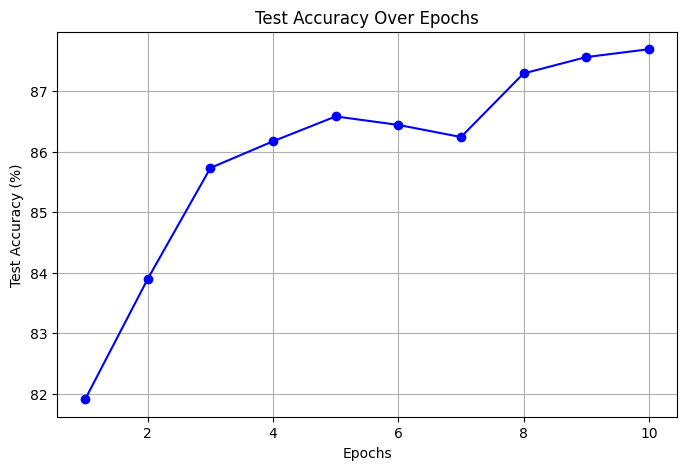

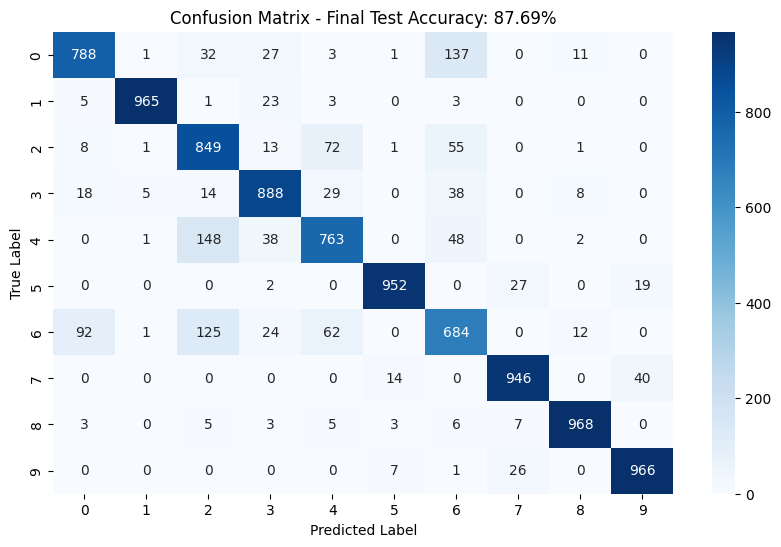

Epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,▁▃▆▆▇▆▆███
Train_accuracy,▁▃▅▅▆▆▆▇██
Train_loss,█▆▄▃▃▂▃▂▁▁
Val_accuracy,▁▄▅▆▆▇▇███
Val_loss,█▅▃▃▂▂▃▁▁▁
epoch,▁▁▁▁▁▁▁▁▁▁
Epoch,10
Test Accuracy,87.69
Train_accuracy,90.90926
Train_loss,0.45268


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb

def train_best_model_and_plot_confusion_matrix():
    wandb.init(project="DA6401_Assignment1_ma23m011", name="Best Model - Conf Matrix")

    # Train Best Model
    best_model = NeuralNetwork(
        input_size=784,
        hidden_layers=best_config['hidden_layers'],
        output_size=10,
        learning_rate=best_config['learning_rate'],
        optimizer=best_config['optimizer'],
        weight_init=best_config['weight_init'],
        activation=best_config['activation'],
        weight_decay=best_config['weight_decay']
    )

    num_epochs = best_config['epochs']
    batch_size = best_config['batch_size']

    # Store test accuracy for plotting
    test_accuracies = []

    for epoch in range(num_epochs):
        best_model.train(x_train, y_train, x_val, y_val, epochs=1, batch_size=batch_size)

        # Forward pass to get predictions on test set
        y_pred_probs = best_model.forward(x_test)[0][-1]  # Get softmax output
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Compute test accuracy
        accuracy = np.sum(y_pred == y_true) / y_true.shape[0]
        test_accuracies.append(accuracy * 100)  # Convert to percentage

        print(f"Epoch {epoch+1}: Test Accuracy = {accuracy*100:.2f}%")

        # Log accuracy per epoch to WandB
        wandb.log({"Test Accuracy": accuracy * 100, "Epoch": epoch + 1})

    # Plot Test Accuracy Over Epochs
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', linestyle='-', color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy Over Epochs")
    plt.grid()

    # Log the accuracy plot
    wandb.log({"Test Accuracy Plot": wandb.Image(plt)})
    plt.show()

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Final Test Accuracy: {accuracy*100:.2f}%")

    # Log confusion matrix to WandB
    wandb.log({"Confusion Matrix": wandb.Image(fig)})

    plt.show()

# Run the Sweep
wandb.agent(sweep_id_conf_matrix, function=train_best_model_and_plot_confusion_matrix)

In [ ]:
# Define Modified Neural Network
class ModifiedNeuralNetwork(NeuralNetwork):
    def __init__(self, loss_function="cross_entropy", **kwargs):
        super().__init__(**kwargs)
        self.loss_function = loss_function

    def compute_loss(self, y_true, y_pred):
        # Compute loss based on loss function.
        if self.loss_function == "cross_entropy":
            return -np.sum(y_true * np.log(y_pred + self.epsilon)) / y_true.shape[0]
        elif self.loss_function == "squared_error":
            return np.mean((y_true - y_pred) ** 2)

    def train(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        #Train the neural network using mini-batch gradient descent
        num_samples = X_train.shape[0]
        loss_history = []  # Store loss values per epoch

        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                #Use forward pass
                activations, z_values = self.forward(X_batch)

                # Compute gradients
                gradients_w, gradients_b = self.backward(X_batch, y_batch, activations, z_values)

                # Update weights
                self.update_weights(gradients_w, gradients_b)

            # Compute training loss
            train_activations, _ = self.forward(X_train)
            train_loss = self.compute_loss(y_train, train_activations[-1])
            loss_history.append(train_loss)

            print(f"Epoch {epoch+1}: Loss = {train_loss:.4f}")

            # Log loss per epoch in WandB
            wandb.log({f"{self.loss_function} Loss": train_loss, "Epoch": epoch})

        return loss_history  # Return loss values for plotting


Epoch 1: Loss = 0.5014
Epoch 2: Loss = 0.3843
Epoch 3: Loss = 0.3727
Epoch 4: Loss = 0.3283
Epoch 5: Loss = 0.2955
Epoch 6: Loss = 0.2905
Epoch 7: Loss = 0.2826
Epoch 8: Loss = 0.2924
Epoch 9: Loss = 0.2616
Epoch 10: Loss = 0.2461
Epoch 1: Loss = 0.0235
Epoch 2: Loss = 0.0208
Epoch 3: Loss = 0.0199
Epoch 4: Loss = 0.0167
Epoch 5: Loss = 0.0160
Epoch 6: Loss = 0.0163
Epoch 7: Loss = 0.0154
Epoch 8: Loss = 0.0148
Epoch 9: Loss = 0.0149
Epoch 10: Loss = 0.0139


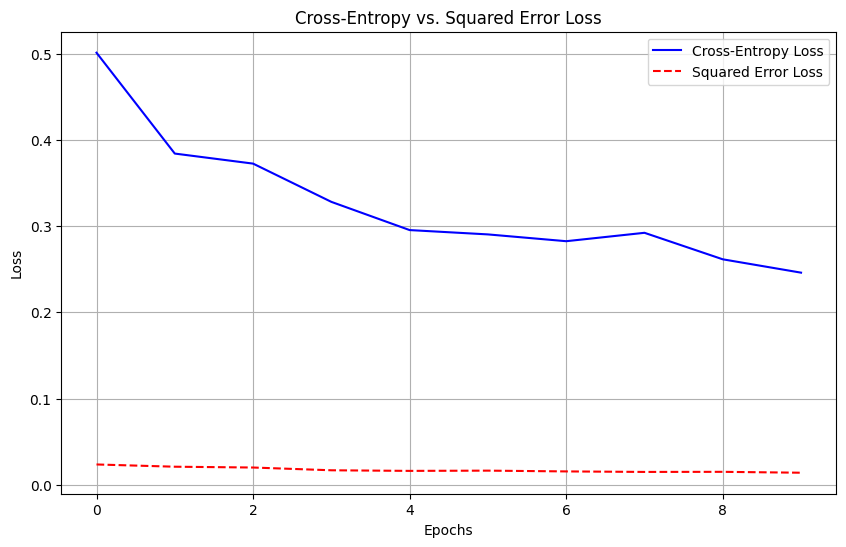

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

# Initialize WandB
wandb.init(project="DA6401_Assignment1_ma23m011", name="loss_comparison")


#Train with Cross-Entropy Loss
cross_entropy_model = ModifiedNeuralNetwork(
    input_size=784, hidden_layers=[128]*5, output_size=10,
    learning_rate=0.001, optimizer="sgd", weight_init="xavier",
    activation="relu", weight_decay=0.0005, loss_function="cross_entropy"
)

cross_entropy_losses = cross_entropy_model.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=64)

# Train with Squared Error Loss
squared_error_model = ModifiedNeuralNetwork(
    input_size=784, hidden_layers=[128]*5, output_size=10,
    learning_rate=0.001, optimizer="sgd", weight_init="xavier",
    activation="relu", weight_decay=0.0005, loss_function="squared_error"
)

squared_error_losses = squared_error_model.train(x_train, y_train, x_val, y_val, epochs=10, batch_size=64)

# Plot the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(cross_entropy_losses, label="Cross-Entropy Loss", color="blue")
plt.plot(squared_error_losses, label="Squared Error Loss", color="red", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Cross-Entropy vs. Squared Error Loss")
plt.legend()
plt.grid()

# Log the loss plot to WandB
wandb.log({"Loss Comparison Plot": wandb.Image(plt)})
plt.show()

In [ ]:
import wandb
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten the data
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

#Train and Evaluate Function
def train_and_evaluate(config, name):
    wandb.init(project="DA6401_Assignment1_ma23m011", name=name, reinit=True)

    # Train the model with given config
    model = ModifiedNeuralNetwork(
        input_size=784, hidden_layers=config['hidden_layers'],
        output_size=10, learning_rate=config['learning_rate'],
        optimizer=config['optimizer'], weight_init=config['weight_init'],
        activation=config['activation'], weight_decay=config['weight_decay']
    )

    num_epochs = 10
    loss_values = []  # store loss per epoch
    test_accuracies = []  # store test accuracy per epoch

    for epoch in range(num_epochs):
        train_loss = model.train(x_train, y_train, x_test, y_test, epochs=1, batch_size=config['batch_size'])
        loss_values.append(train_loss[-1])  # Store last loss of the epoch

        # Compute test accuracy
        y_pred_probs = model.forward(x_test)[0][-1]
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = np.sum(y_pred == y_true) / y_true.shape[0]
        test_accuracies.append(accuracy * 100)

        # Log to WandB
        wandb.log({"Epoch": epoch + 1, "Test Accuracy": accuracy * 100, f"{name} Loss": train_loss[-1]})

    # Plot Loss Curve
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{name} Loss Over Epochs")
    plt.grid()
    wandb.log({f"{name} Loss Plot": wandb.Image(plt)})
    plt.close()

    # Plot Test Accuracy Curve
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', linestyle='-', color='g')
    plt.xlabel("Epochs")
    plt.ylabel("Test Accuracy (%)")
    plt.title(f"{name} Test Accuracy Over Epochs")
    plt.grid()
    wandb.log({f"{name} Accuracy Plot": wandb.Image(plt)})
    plt.close()

    print(f"{name} - Final Test Accuracy: {test_accuracies[-1]:.2f}%")
    return test_accuracies[-1]

# Run 3 Best Configurations based on fshoin mnist accuracy
configs = [
    {"hidden_layers": [128]*5, "activation": "relu", "optimizer": "sgd", "learning_rate": 0.001, "batch_size": 64, "weight_decay": 0.0005, "weight_init": "xavier"},
    {"hidden_layers": [64]*3, "activation": "sigmoid", "optimizer": "adam", "learning_rate": 0.001, "batch_size": 64, "weight_decay": 0.0005, "weight_init": "xavier"},
    {"hidden_layers": [128]*5, "activation": "tanh", "optimizer": "rmsprop", "learning_rate": 0.001, "batch_size":64, "weight_decay": 0.0005, "weight_init": "xavier"}
]

results = []
for i, config in enumerate(configs):
    accuracy = train_and_evaluate(config, f"Config {i+1} Final")
    results.append((f"Config {i+1}", accuracy))

# Print Final Results
print("\nFinal Results on MNIST:")
for config_name, acc in results:
    print(f"{config_name}: {acc:.2f}%")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
cross_entropy Loss,█▅▄▃▂▂▂▂▁▁
squared_error Loss,█▆▅▃▃▃▂▂▂▁
Epoch,9
cross_entropy Loss,0.2461
squared_error Loss,0.01387


Epoch 1: Loss = 0.1720
Epoch 1: Loss = 0.1085
Epoch 1: Loss = 0.0696
Epoch 1: Loss = 0.0610
Epoch 1: Loss = 0.0466
Epoch 1: Loss = 0.0398
Epoch 1: Loss = 0.0316
Epoch 1: Loss = 0.0254
Epoch 1: Loss = 0.0262
Epoch 1: Loss = 0.0197
Config 1 Final - Final Test Accuracy: 97.58%


Config 1 Final Loss,█▅▃▃▂▂▂▁▁▁
Epoch,▁▂▁▂▁▃▁▄▁▅▁▅▁▆▁▇▁▇▁█
Test Accuracy,▁▅▇▇▇▇██▇█
cross_entropy Loss,█▅▃▃▂▂▂▁▁▁
Config 1 Final Loss,0.01966
Epoch,10
Test Accuracy,97.58
cross_entropy Loss,0.01966


Epoch 1: Loss = 0.3396
Epoch 1: Loss = 0.2106
Epoch 1: Loss = 0.1545
Epoch 1: Loss = 0.1232
Epoch 1: Loss = 0.1019
Epoch 1: Loss = 0.0960
Epoch 1: Loss = 0.0759
Epoch 1: Loss = 0.0627
Epoch 1: Loss = 0.0546
Epoch 1: Loss = 0.0517
Config 2 Final - Final Test Accuracy: 96.74%


Config 2 Final Loss,█▅▃▃▂▂▂▁▁▁
Epoch,▁▂▁▂▁▃▁▄▁▅▁▅▁▆▁▇▁▇▁█
Test Accuracy,▁▄▆▇▇▇████
cross_entropy Loss,█▅▃▃▂▂▂▁▁▁
Config 2 Final Loss,0.05173
Epoch,10
Test Accuracy,96.74
cross_entropy Loss,0.05173


Epoch 1: Loss = 0.1769
Epoch 1: Loss = 0.1349
Epoch 1: Loss = 0.1070
Epoch 1: Loss = 0.0610
Epoch 1: Loss = 0.0429
Epoch 1: Loss = 0.0377
Epoch 1: Loss = 0.0421
Epoch 1: Loss = 0.0216
Epoch 1: Loss = 0.0216
Epoch 1: Loss = 0.0174
Config 3 Final - Final Test Accuracy: 97.63%

Final Results on MNIST:
Config 1: 97.58%
Config 2: 96.74%
Config 3: 97.63%
